# Looking at 08.03.2024 mochi results (notebooks M0-M1) on DTS datasets

1. Allowing for 1st and 2nd order terms
2. Fitting the following functions for now: Linear, Sigmoid, and ELU
3. Using `l2_regularization_factor` parameter = 10^(-5)

Using **all live variants + subsampled dead (9%)** from the files generated in notebook M0: 

`mochi_live_and_subsampled_dead_variants_DTS01_20240308.tsv` and so on for all the DTS datasets (01, 02, 05, 10, 11, 13, 14 and 15)

11.03.2024

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from pymochi.models import MochiTask

In [2]:
pd.set_option('display.max_rows', 500)

In [3]:
results_dir = '/lustre/scratch126/gengen/projects/amyloid_beta_epistasis/DTS_joint_analysis/mochi_results/'


In [4]:
filedir = '/lustre/scratch126/gengen/projects/amyloid_beta_epistasis/DTS_joint_analysis/files/'

datasets = ['DTS01',
            #'DTS02',
            'DTS05',#'DTS10','DTS11','DTS13',
            #'DTS14',
            #'DTS15'
           ]

filenames = {}

for dataset in datasets:
    filenames[dataset] = 'mochi_all_variants_' + dataset + '_20240424.tsv'

output_dir = '/lustre/scratch126/gengen/projects/amyloid_beta_epistasis/DTS_joint_analysis/mochi_results/'

In [5]:
l2_regularisation_factor_value = '1e-05'

transformations = ['Sigmoid', 
                   #'ELU', 'Linear'
                  ] 


In [6]:
predictions = {}

mochi_tasks = {}

for transformation in transformations: 
    print(transformation)
    
    curr_path = results_dir + '20240424_max_terms_order_2_' + transformation + '_l2_regularization_factor_' + l2_regularisation_factor_value + '_DTS01_DT05_all_variants/'

    #curr_paths_indiv_models = 
    curr_key = transformation + '_DTS01_DT05_all_variants_1st_and_2nd_order'

    predictions[curr_key] = pd.read_csv(curr_path + '/predictions/predicted_phenotypes_all.txt',
                                                                       sep='\t') 
    predictions[curr_key].phenotype = [str(i) for i in predictions[curr_key].phenotype]

    # adding a column with residual values
    observed_phenotype_col = 'fitness'
    predicted_phenotype_col = 'fold_1'
    residuals_col = 'residual_pred_vs_obs'
    predictions[curr_key][residuals_col] = predictions[curr_key][predicted_phenotype_col] - predictions[curr_key][observed_phenotype_col]


    # loading previous task / model to have some of the parameters here
    mochi_tasks[curr_key] = MochiTask(directory = curr_path)
    
    # rescaling energies to be in kcal/mol
    # scaling twice
    # using slope and intercept bw DTS and doubles common terms derived in notebook M3
    
    intercept_value = -0.15589508632224625
    slope_value = 0.41604357
    
    all_folds = [int(i) for i in list(set(predictions[curr_key].loc[predictions[curr_key].Fold.isna()==False,'Fold']))]
    for fold in all_folds:
        predictions[curr_key]['fold_' + str(fold) + '_additive_trait0'] = (predictions[curr_key]['fold_' + str(fold) + '_additive_trait0'] + intercept_value)/(-slope_value)
        


Sigmoid


In [7]:
predictions['Sigmoid_DTS01_DT05_all_variants_1st_and_2nd_order'].columns

Index(['aa_seq', 'Nham_aa', 'WT', 'fitness', 'sigma', 'phenotype',
       'Nucleation_DTS01', 'Nucleation_DTS05', 'fold_1', 'fold_2', 'fold_3',
       'fold_4', 'fold_5', 'fold_6', 'fold_7', 'fold_8', 'fold_9', 'fold_10',
       'mean', 'std', 'ci95', 'Fold', 'fold_1_additive_trait0',
       'fold_2_additive_trait0', 'fold_3_additive_trait0',
       'fold_4_additive_trait0', 'fold_5_additive_trait0',
       'fold_6_additive_trait0', 'fold_7_additive_trait0',
       'fold_8_additive_trait0', 'fold_9_additive_trait0',
       'fold_10_additive_trait0', 'residual_pred_vs_obs'],
      dtype='object')

In [8]:
type(predictions['Sigmoid_DTS01_DT05_all_variants_1st_and_2nd_order'].phenotype[0])

str

In [9]:
# observed is fitness
# predicted is 

In [10]:
# importing plotting function from MoCHI for predicted vs observed phenotype
def plot_test_performance_multiplot(
        #self,
        input_df,
    axis,
    Title=None,
        #output_path_prefix
):
        """
        Plot model performance on test data.

        :param input_df: Input DataFrame with all predictions (required).
        :param output_path_prefix: Output file path (required).
        :returns: Nothing.
        """ 

        #Subset to held out variants and relevant columns
        all_folds = [int(i) for i in list(set(input_df.loc[input_df.Fold.isna()==False,'Fold']))]
        all_folds = [i for i in all_folds if 'fold_'+ str(i) in input_df.columns] 
        rel_cols = ['fitness', 'phenotype', 'Fold']+['fold_'+str(i) for i in all_folds]
        result_df = input_df.loc[input_df.Fold.isna()==False,rel_cols]
        
        #Observed phenotype
        result_df['Observed phenotype'] = result_df['fitness']
        
        #Predicted phenotype
        for i in all_folds:
            result_df.loc[result_df.Fold==i,'Predicted phenotype'] = result_df.loc[result_df.Fold==i,'fold_'+str(i)]

        #Plot performance for all phenotypes
        for i in list(set(result_df.phenotype)):
            #Plot
            plot_df = result_df.loc[result_df.phenotype==i,:]
            #fig, ax = plt.subplots()  # Create a figure containing a single axes.
            plot_df.reset_index(drop = True, inplace = True)
            n_bin = 50
            cmap = LinearSegmentedColormap.from_list('whiteblack', ['white', 'black'], N=n_bin)
            z = axis.hexbin(
                x = 'Observed phenotype',
                y = 'Predicted phenotype',
                data = plot_df, gridsize = 100, cmap = cmap, bins = 'log')
            #Color scale
            plt.colorbar(z, ax=axis
                        )
            #Guides
            axis.axline((0.1, 0.1), slope=1, linestyle = "dashed", color = 'black')
            axis.axhline(y = 0, color = 'black', linestyle = '--')
            axis.axvline(x = 0, color = 'black', linestyle = '--')
            #Labels
            #axis.set_title(self.task.data.phenotype_names[int(i)-1])
            #plt.xlabel('Observed phenotype', size = 14)
            #plt.ylabel('Predicted phenotype', size = 14)
            axis.set_aspect("equal")
            #R-squared
            from matplotlib.offsetbox import AnchoredText
            cor_coef = np.corrcoef(
                result_df.loc[result_df.phenotype==i,'Observed phenotype'], 
                result_df.loc[result_df.phenotype==i,'Predicted phenotype'])[0,1]
            at = AnchoredText(
                r'$R^2 = $'+str(round(np.power(cor_coef, 2), 2)), 
                prop=dict(size=14), frameon=False, loc='upper left')
            axis.text(0.5,-3,r'$R^2 = $'+str(round(np.power(cor_coef, 2), 2)))
            axis.title.set_text(Title)
            #plt.show()
            #Save
            #plt.savefig(output_path_prefix+self.task.data.phenotype_names[int(i)-1]+".pdf")

In [11]:
predictions['Sigmoid_DTS01_DT05_all_variants_1st_and_2nd_order']

aa_seq  Nham_aa   WT   fitness  \
0      DAEFRHDSGYEVHHQKLVFFAEDVGSNKGAIIGIIIGGMLLA        6  NaN -6.453303   
1      DAEFRHDSGYEVHHQKLVFFAEDVGSNKGAIIGIIIGGVMMA        5  NaN -6.689845   
2      DAEFRHDSGYEVHHQKLVFFAEDVGSNKGAIIGIIIGGVIMA        5  NaN -6.437139   
3      DAEFRHDSGYEVHHQKLVFFAEDVGSNKGAIIGIIMGGFMFA        6  NaN -6.033716   
4      DAEFRHDSGYEVHHQKLVFFAEDVGSNKGAIIGIIVGGIILA        5  NaN -2.676460   
...                                           ...      ...  ...       ...   
42949  DAEFRHDSGYEVHHQKLVLLAEDLGSNKGALFGMMVGGVVIA        6  NaN -0.447388   
42950  DAEFRHDSGYEVHHQKLVLLAEDLGSNKGALFGLMVGGVVIA        5  NaN  1.447367   
42951  DAEFRHDSGYEVHHQKLVLLAEDLGSNKGALLGVMVGGVVIA        6  NaN  0.034470   
42952  DAEFRHDSGYEVHHQKLVLLAEDLGSNKGALLGFMVGGVVIA        6  NaN -0.625840   
42953  DAEFRHDSGYEVHHQKLVFFAEDVGSNKGAIIGLMVGGVVIA        0  1.0  0.000000   

            sigma phenotype  Nucleation_DTS01  Nucleation_DTS05    fold_1  \
0        1.343676         1               1.0               0.0 -6.285793   
1        0.603279         1               1.0               0.0 -5.273715   
2        1.977776         1               1.0               0.0 -4.841362   
3        0.851058         1               1.0               0.0 -5.810790   
4        1.389283         1               1.0               0.0 -5.115503   
...           ...       ...               ...               ...       ...   
42949    1.620909         2               0.0               1.0  1.349459   
42950    0.953764         2               0.0               1.0  1.316327   
42951    0.736629         2               0.0               1.0  1.244855   
42952    1.737394         2               0.0               1.0  1.203561   
42953  100.000000         2               0.0               1.0  5.575826   

         fold_2  ...  fold_2_additive_trait0  fold_3_additive_trait0  \
0     -6.248091  ...               12.247343               13.816591   
1     -5.766933  ...                5.842145                4.794650   
2     -5.432316  ...                4.508566                2.492690   
3     -6.018681  ...                7.531888                8.927804   
4     -5.702139  ...                5.533573                3.292818   
...         ...  ...                     ...                     ...   
42949  1.306331  ...                8.374195                8.484146   
42950  1.341302  ...                7.889557                8.157374   
42951  1.227093  ...               10.018350               11.052059   
42952  1.180837  ...               11.991090               12.657468   
42953  5.554196  ...               -3.460030               -3.390734   

       fold_4_additive_trait0  fold_5_additive_trait0  fold_6_additive_trait0  \
0                   10.888439               14.124687               10.808576   
1                    3.074040                4.694808                4.695479   
2                    3.320613                2.965912                3.084474   
3                    7.076079                7.408114                7.987544   
4                    6.342577                6.092372                5.082613   
...                       ...                     ...                     ...   
42949                7.394062                7.467401                8.739989   
42950                7.813603                6.935663                9.442461   
42951                9.781807               11.844106               10.706475   
42952               11.166934               13.059163               11.161243   
42953               -3.753090               -3.431881               -3.553689   

       fold_7_additive_trait0  fold_8_additive_trait0  fold_9_additive_trait0  \
0                   12.960170               11.119486               10.693330   
1                    5.347596                4.368953                4.203564   
2                    3.067038                3.467553                2.691845   
3                    5.539812  

In [12]:
predictions['Sigmoid_DTS01_DT05_all_variants_1st_and_2nd_order']['phenotype'][0]

'1'

## Results here will be plotted for each of the datasets' predictions

For 2 phenotypes/datasets:
- DTS01
- DTS05

In [13]:
transformations

['Sigmoid']

In [14]:
predictions['Sigmoid_DTS01_DT05_all_variants_1st_and_2nd_order']

aa_seq  Nham_aa   WT   fitness  \
0      DAEFRHDSGYEVHHQKLVFFAEDVGSNKGAIIGIIIGGMLLA        6  NaN -6.453303   
1      DAEFRHDSGYEVHHQKLVFFAEDVGSNKGAIIGIIIGGVMMA        5  NaN -6.689845   
2      DAEFRHDSGYEVHHQKLVFFAEDVGSNKGAIIGIIIGGVIMA        5  NaN -6.437139   
3      DAEFRHDSGYEVHHQKLVFFAEDVGSNKGAIIGIIMGGFMFA        6  NaN -6.033716   
4      DAEFRHDSGYEVHHQKLVFFAEDVGSNKGAIIGIIVGGIILA        5  NaN -2.676460   
...                                           ...      ...  ...       ...   
42949  DAEFRHDSGYEVHHQKLVLLAEDLGSNKGALFGMMVGGVVIA        6  NaN -0.447388   
42950  DAEFRHDSGYEVHHQKLVLLAEDLGSNKGALFGLMVGGVVIA        5  NaN  1.447367   
42951  DAEFRHDSGYEVHHQKLVLLAEDLGSNKGALLGVMVGGVVIA        6  NaN  0.034470   
42952  DAEFRHDSGYEVHHQKLVLLAEDLGSNKGALLGFMVGGVVIA        6  NaN -0.625840   
42953  DAEFRHDSGYEVHHQKLVFFAEDVGSNKGAIIGLMVGGVVIA        0  1.0  0.000000   

            sigma phenotype  Nucleation_DTS01  Nucleation_DTS05    fold_1  \
0        1.343676         1               1.0               0.0 -6.285793   
1        0.603279         1               1.0               0.0 -5.273715   
2        1.977776         1               1.0               0.0 -4.841362   
3        0.851058         1               1.0               0.0 -5.810790   
4        1.389283         1               1.0               0.0 -5.115503   
...           ...       ...               ...               ...       ...   
42949    1.620909         2               0.0               1.0  1.349459   
42950    0.953764         2               0.0               1.0  1.316327   
42951    0.736629         2               0.0               1.0  1.244855   
42952    1.737394         2               0.0               1.0  1.203561   
42953  100.000000         2               0.0               1.0  5.575826   

         fold_2  ...  fold_2_additive_trait0  fold_3_additive_trait0  \
0     -6.248091  ...               12.247343               13.816591   
1     -5.766933  ...                5.842145                4.794650   
2     -5.432316  ...                4.508566                2.492690   
3     -6.018681  ...                7.531888                8.927804   
4     -5.702139  ...                5.533573                3.292818   
...         ...  ...                     ...                     ...   
42949  1.306331  ...                8.374195                8.484146   
42950  1.341302  ...                7.889557                8.157374   
42951  1.227093  ...               10.018350               11.052059   
42952  1.180837  ...               11.991090               12.657468   
42953  5.554196  ...               -3.460030               -3.390734   

       fold_4_additive_trait0  fold_5_additive_trait0  fold_6_additive_trait0  \
0                   10.888439               14.124687               10.808576   
1                    3.074040                4.694808                4.695479   
2                    3.320613                2.965912                3.084474   
3                    7.076079                7.408114                7.987544   
4                    6.342577                6.092372                5.082613   
...                       ...                     ...                     ...   
42949                7.394062                7.467401                8.739989   
42950                7.813603                6.935663                9.442461   
42951                9.781807               11.844106               10.706475   
42952               11.166934               13.059163               11.161243   
42953               -3.753090               -3.431881               -3.553689   

       fold_7_additive_trait0  fold_8_additive_trait0  fold_9_additive_trait0  \
0                   12.960170               11.119486               10.693330   
1                    5.347596                4.368953                4.203564   
2                    3.067038                3.467553                2.691845   
3                    5.539812  

In [16]:
l2_regularisation_factor_values = ['1e-05']

In [ ]:
# all the results for run with all 3 doubles datasets
# N_max_inter = 1 everywhere

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5,2))

#fig.tight_layout()
#fig.subplots_adjust(hspace=0.4)

#fig.supxlabel('Observed phenotype')
#fig.supylabel('Predicted phenotype')

# plotting for eLife dataset
curr_phenotype = 'DTS01' # eLife

for i in range(len(transformations)):
    print(i)
    curr_transformation = transformations[i]
    
    for j in range(len(l2_regularisation_factor_values)):
        print(j)
        curr_l2_regularisation_factor_value = l2_regularisation_factor_values[j]
        
        # separating input table by phenotype/dataset into 3
    
        curr_predictions_all = predictions['Sigmoid_DTS01_DT05_all_variants_1st_and_2nd_order']
        curr_predictions_DTS01 = curr_predictions_all[curr_predictions_all['phenotype'] == curr_phenotype]
        #curr_predictions_2 = curr_predictions_all[curr_predictions_all['phenotype'] == '2']
        #curr_predictions_3 = curr_predictions_all[curr_predictions_all['phenotype'] == '3']
    
        plot_test_performance_multiplot(curr_predictions_DTS01,
                                axis=axs[i, j],
                                 Title = 'DTS01 \n ' + curr_transformation + '\n' + 'l2_' + curr_l2_regularisation_factor_value)
        
#plt.savefig('./figures/20240212_mochi_test_performance_Nucleation_all_3_doubles_1st_ord_terms_allowed_eLife_l2_testing.pdf',
#           bbox_inches = 'tight')

    


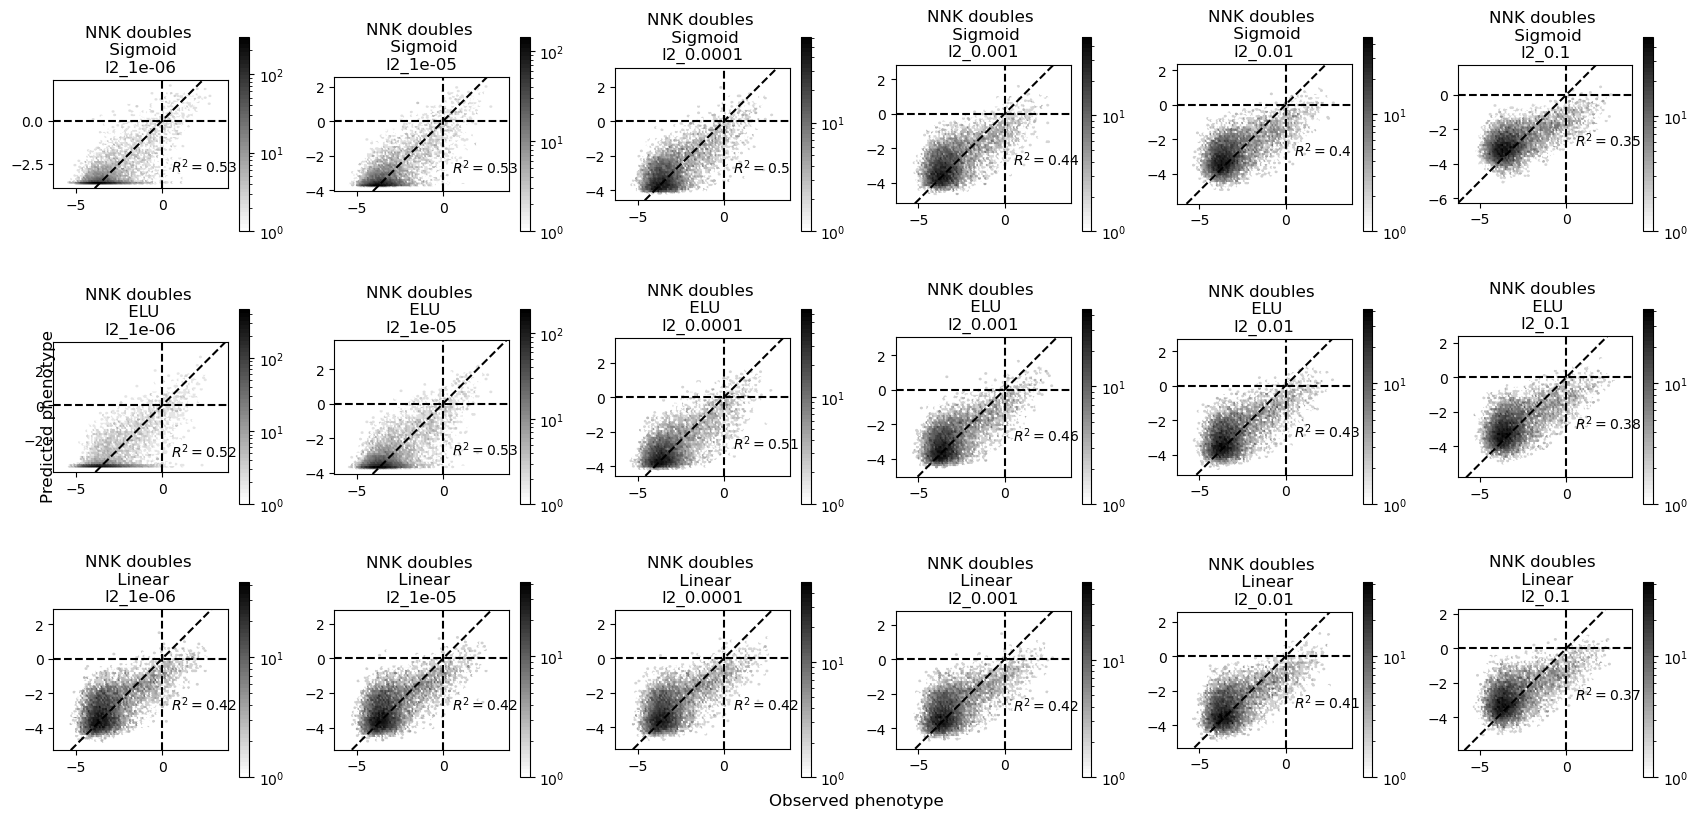

In [15]:
# all the results for run with all 3 doubles datasets
# N_max_inter = 1 everywhere

fig, axs = plt.subplots(len(transformations),len(l2_regularisation_factor_values), 
                        figsize=(17, 8))
fig.tight_layout()
fig.subplots_adjust(hspace=0.4)


fig.supxlabel('Observed phenotype')
fig.supylabel('Predicted phenotype')

# plotting for eLife dataset
curr_phenotype = '2' # NNK doubles

for i in range(len(transformations)):
    curr_transformation = transformations[i]
    
    for j in range(len(l2_regularisation_factor_values)):
        curr_l2_regularisation_factor_value = l2_regularisation_factor_values[j]
        
        # separating input table by phenotype/dataset into 3
    
        curr_predictions_all = predictions[curr_transformation + '_all_3_doubles_datasets_1st_order_l2_' + curr_l2_regularisation_factor_value]
        #curr_predictions_eLife = curr_predictions_all[curr_predictions_all['phenotype'] == '1']
        curr_predictions_NNK = curr_predictions_all[curr_predictions_all['phenotype'] == '2']
        #curr_predictions_3 = curr_predictions_all[curr_predictions_all['phenotype'] == '3']
    
        plot_test_performance_multiplot(curr_predictions_NNK,
                                axis=axs[i, j],
                                 Title = 'NNK doubles \n ' + curr_transformation + '\n' + 'l2_' + curr_l2_regularisation_factor_value)
        
plt.savefig('./figures/20240212_mochi_test_performance_Nucleation_all_3_doubles_1st_ord_terms_allowed_NNK_l2_testing.pdf',
           bbox_inches = 'tight')


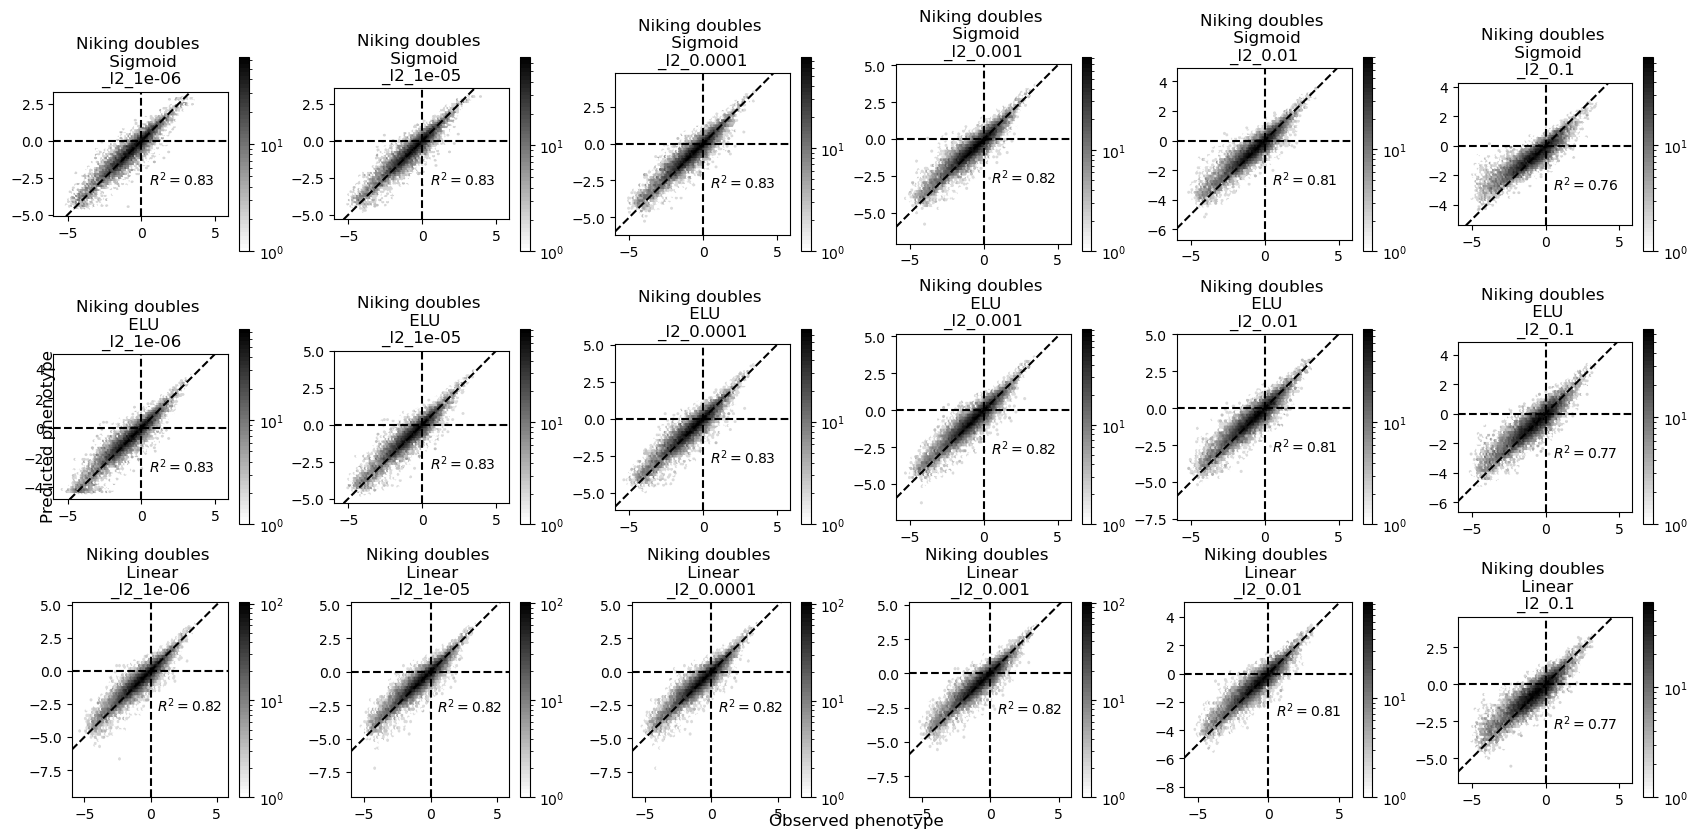

In [16]:
# all the results for run with all 3 doubles datasets
# N_max_inter = 1 everywhere

fig, axs = plt.subplots(len(transformations),len(l2_regularisation_factor_values), 
                        figsize=(17, 8))
fig.tight_layout()
fig.subplots_adjust(hspace=0.4)

fig.supxlabel('Observed phenotype')
fig.supylabel('Predicted phenotype')

# plotting for eLife dataset
curr_phenotype = '3' # Nicking doubles

for i in range(len(transformations)):
    curr_transformation = transformations[i]
    
    for j in range(len(l2_regularisation_factor_values)):
        curr_l2_regularisation_factor_value = l2_regularisation_factor_values[j]
        
        # separating input table by phenotype/dataset into 3
    
        curr_predictions_all = predictions[curr_transformation + '_all_3_doubles_datasets_1st_order_l2_' + curr_l2_regularisation_factor_value]
        #curr_predictions_eLife = curr_predictions_all[curr_predictions_all['phenotype'] == '1']
        #curr_predictions_NNK = curr_predictions_all[curr_predictions_all['phenotype'] == '2']
        curr_predictions_Nicking = curr_predictions_all[curr_predictions_all['phenotype'] == '3']
    
        plot_test_performance_multiplot(curr_predictions_Nicking,
                                axis=axs[i, j],
                                 Title = 'Niking doubles \n ' + curr_transformation + '\n' + '_l2_' + curr_l2_regularisation_factor_value)
        
plt.savefig('./figures/20240212_mochi_test_performance_Nucleation_all_3_doubles_1st_ord_terms_allowed_Nicking_l2_testing.pdf',
           bbox_inches = 'tight')


In [14]:
# produce R^2 table for each of the runs (either all 3 doubles datasets or just NNK and Nicking doubles)

def R_sq(mochi_predictions_table, # global predictions table from mochi (for all phenotypes)
         phenotype # values in column phenotype for relevant phenotype/dataset, str
        ):
    
    input_df = mochi_predictions_table.copy()
    input_df = input_df[input_df['phenotype'] == phenotype]
    all_folds = [int(i) for i in list(set(input_df.loc[input_df.Fold.isna()==False,'Fold']))]
    all_folds = [i for i in all_folds if 'fold_'+ str(i) in input_df.columns]
    rel_cols = ['fitness', 'phenotype', 'Fold']+['fold_'+str(i) for i in all_folds]
    result_df = input_df.loc[input_df.Fold.isna()==False,rel_cols]

    #Observed phenotype
    result_df['Observed phenotype'] = result_df['fitness']

    #Predicted phenotype
    for i in all_folds:
        result_df.loc[result_df.Fold==i,'Predicted phenotype'] = result_df.loc[result_df.Fold==i,'fold_'+str(i)]

    cor_coef = np.corrcoef(
                result_df['Observed phenotype'], 
                result_df['Predicted phenotype'])[0,1]
    R_sq = round(np.power(cor_coef, 2), 2)
    
    return(R_sq)
    

In [15]:
l2_regularisation_factor_values

['1e-06', '1e-05', '0.0001', '0.001', '0.01', '0.1']

In [16]:
# a table for each transformation

R_sq_table_all_3_doubles = {}

for transformation in transformations:
    R_sq_table_all_3_doubles[transformation] = pd.DataFrame(index = ['eLife_doubles','NNK_doubles','Nicking_doubles'], 
                                        columns = l2_regularisation_factor_values)


In [17]:
R_sq_table_all_3_doubles['Sigmoid']

1e-06 1e-05 0.0001 0.001 0.01  0.1
eLife_doubles     NaN   NaN    NaN   NaN  NaN  NaN
NNK_doubles       NaN   NaN    NaN   NaN  NaN  NaN
Nicking_doubles   NaN   NaN    NaN   NaN  NaN  NaN

In [18]:
for transformation in transformations:
    print(transformation)
    
    for l2_regularisation_factor_value in l2_regularisation_factor_values:
        print(l2_regularisation_factor_value)
        R_sq_table_all_3_doubles[transformation].loc['eLife_doubles',l2_regularisation_factor_value] = R_sq(predictions[transformation + '_all_3_doubles_datasets_1st_order_l2_' + l2_regularisation_factor_value], '1')
        R_sq_table_all_3_doubles[transformation].loc['NNK_doubles',l2_regularisation_factor_value] = R_sq(predictions[transformation + '_all_3_doubles_datasets_1st_order_l2_' + l2_regularisation_factor_value], '2')
        R_sq_table_all_3_doubles[transformation].loc['Nicking_doubles',l2_regularisation_factor_value] = R_sq(predictions[transformation + '_all_3_doubles_datasets_1st_order_l2_' + l2_regularisation_factor_value], '3')


Sigmoid
1e-06
1e-05
0.0001
0.001
0.01
0.1
ELU
1e-06
1e-05
0.0001
0.001
0.01
0.1
Linear
1e-06
1e-05
0.0001
0.001
0.01
0.1


In [19]:
R_sq_table_all_3_doubles['Sigmoid']

1e-06 1e-05 0.0001 0.001  0.01   0.1
eLife_doubles    0.79  0.79   0.79  0.77  0.75  0.71
NNK_doubles      0.53  0.53    0.5  0.44   0.4  0.35
Nicking_doubles  0.83  0.83   0.83  0.82  0.81  0.76

In [20]:
R_sq_table_all_3_doubles['ELU']

1e-06 1e-05 0.0001 0.001  0.01   0.1
eLife_doubles    0.79  0.79   0.79  0.78  0.76  0.73
NNK_doubles      0.52  0.53   0.51  0.46  0.43  0.38
Nicking_doubles  0.83  0.83   0.83  0.82  0.81  0.77

In [21]:
R_sq_table_all_3_doubles['Linear']

1e-06 1e-05 0.0001 0.001  0.01   0.1
eLife_doubles    0.75  0.75   0.75  0.75  0.75  0.72
NNK_doubles      0.42  0.42   0.42  0.42  0.41  0.37
Nicking_doubles  0.82  0.82   0.82  0.82  0.81  0.77

In [22]:
#R_sq_table_all_3_doubles['Sigmoid'].to_csv('./mochi_results/20240212_R_sq_table_all_3_doubles_l2_testing_Sigmoid.csv')
#R_sq_table_all_3_doubles['ELU'].to_csv('./mochi_results/20240212_R_sq_table_all_3_doubles_l2_testing_ELU.csv')
#R_sq_table_all_3_doubles['Linear'].to_csv('./mochi_results/20240212_R_sq_table_all_3_doubles_l2_testing_Linear.csv')

# make global epistasis plots + save them

In [9]:
l2_regularisation_factor_values

NameError: name 'l2_regularisation_factor_values' is not defined

In [10]:
def plot_observed_phenotype_vs_additivetrait_multiplot(
        #self,
        input_df,
        run_key, # Linear_not_dead; etc, the model run (transformation + file handle) 
        #output_path_prefix,
        phenotype, # phenotype value (str) from input_df['phenotype'] to plot stuff for
        axis,
        transformation = None,
        Title = None,
        folds = None,
        RT = None):
        """
        Plot observed phenoypte versus additive trait (1-dimensional additive traits only).

        :param input_df: Input DataFrame with all predictions (required).
        :param output_path_prefix: Output file path (required).
        :param folds: list of cross-validation folds (default:None i.e. all).
        :param RT: R=gas constant (in kcal/K/mol) * T=Temperature (in K) (optional).
        :returns: Nothing.
        """ 
        #Set folds if not supplied
        if folds==None:
            folds = [i+1 for i in range(mochi_tasks[run_key].data.k_folds)]

        #Set RT if not supplied
        if RT==None:
            RT = 1

        fold = folds[0] # it is 1 now
        observed_phenotype_col = 'fitness'

        #Plot performance for all 1-dimensional phenotypes
        
        i = int(phenotype) - 1 # phenotype counter, for phenotype 1 should be 0, and so on
                
        if len(mochi_tasks[run_key].data.model_design.loc[i,'trait'])==1:
            predicted_phenotype_col = 'fold_'+str(fold)
            additive_trait_col = predicted_phenotype_col+'_additive_trait0' # this will be 'fold_1_additive_trait0'
            # sort by fold_1_additive_trait0
            plot_df_sort = input_df.loc[input_df.phenotype==str(i+1),:].sort_values(additive_trait_col)
            plot_df_sort.reset_index(drop = True, inplace = True)
                
            
            #Convert units
            plot_df_sort[additive_trait_col+"_kcal/mol"] = plot_df_sort[additive_trait_col]*RT
            additive_trait_col = additive_trait_col+"_kcal/mol"
            #fig, ax = plt.subplots()
            n_bin = 50
            cmap = LinearSegmentedColormap.from_list('whiteblack', ['white', 'black'], N=n_bin)
            
            z = axis.hexbin(
                    x = additive_trait_col,
                    y = observed_phenotype_col,
                    data = plot_df_sort.loc[plot_df_sort.phenotype==str(i+1),:], gridsize = 100, cmap = cmap, bins = 'log')
            axis.plot(
                    plot_df_sort.loc[plot_df_sort.phenotype==str(i+1),additive_trait_col], 
                    plot_df_sort.loc[plot_df_sort.phenotype==str(i+1),predicted_phenotype_col], mfc='none', 
                    linestyle = "-", color = 'red'
                )
            #Color scale
            plt.colorbar(z, ax=axis)
            #Guides
            axis.axhline(y = 0, color = 'black', linestyle = '--')
            axis.axvline(x = 0, color = 'black', linestyle = '--')
                
            #Labels
            #ax.set_title(mochi_tasks[run_key].data.phenotype_names[int(i)])
            axis.set_title(Title, fontsize = 10)
            if transformation != None:
                axis.set_ylabel(str(transformation) + '\n transformation', size = 14)
            #axis.set_xlabel('Additive trait (-dEa)', size = 14)
            #Save
            #plt.savefig(output_path_prefix+self.task.data.phenotype_names[int(i)]+".pdf")

In [11]:
phenotypes = np.unique(predictions['Sigmoid_DTS01_DT05_all_variants_1st_and_2nd_order']['phenotype'])

In [12]:
phenotypes

array(['1', '2'], dtype=object)

In [14]:
predictions['Sigmoid_DTS01_DT05_all_variants_1st_and_2nd_order']

aa_seq  Nham_aa   WT   fitness  \
0      DAEFRHDSGYEVHHQKLVFFAEDVGSNKGAIIGIIIGGMLLA        6  NaN -6.453303   
1      DAEFRHDSGYEVHHQKLVFFAEDVGSNKGAIIGIIIGGVMMA        5  NaN -6.689845   
2      DAEFRHDSGYEVHHQKLVFFAEDVGSNKGAIIGIIIGGVIMA        5  NaN -6.437139   
3      DAEFRHDSGYEVHHQKLVFFAEDVGSNKGAIIGIIMGGFMFA        6  NaN -6.033716   
4      DAEFRHDSGYEVHHQKLVFFAEDVGSNKGAIIGIIVGGIILA        5  NaN -2.676460   
...                                           ...      ...  ...       ...   
42949  DAEFRHDSGYEVHHQKLVLLAEDLGSNKGALFGMMVGGVVIA        6  NaN -0.447388   
42950  DAEFRHDSGYEVHHQKLVLLAEDLGSNKGALFGLMVGGVVIA        5  NaN  1.447367   
42951  DAEFRHDSGYEVHHQKLVLLAEDLGSNKGALLGVMVGGVVIA        6  NaN  0.034470   
42952  DAEFRHDSGYEVHHQKLVLLAEDLGSNKGALLGFMVGGVVIA        6  NaN -0.625840   
42953  DAEFRHDSGYEVHHQKLVFFAEDVGSNKGAIIGLMVGGVVIA        0  1.0  0.000000   

            sigma phenotype  Nucleation_DTS01  Nucleation_DTS05    fold_1  \
0        1.343676         1               1.0               0.0 -6.285793   
1        0.603279         1               1.0               0.0 -5.273715   
2        1.977776         1               1.0               0.0 -4.841362   
3        0.851058         1               1.0               0.0 -5.810790   
4        1.389283         1               1.0               0.0 -5.115503   
...           ...       ...               ...               ...       ...   
42949    1.620909         2               0.0               1.0  1.349459   
42950    0.953764         2               0.0               1.0  1.316327   
42951    0.736629         2               0.0               1.0  1.244855   
42952    1.737394         2               0.0               1.0  1.203561   
42953  100.000000         2               0.0               1.0  5.575826   

         fold_2  ...  fold_2_additive_trait0  fold_3_additive_trait0  \
0     -6.248091  ...               12.622052               14.191300   
1     -5.766933  ...                6.216853                5.169359   
2     -5.432316  ...                4.883275                2.867399   
3     -6.018681  ...                7.906597                9.302513   
4     -5.702139  ...                5.908282                3.667527   
...         ...  ...                     ...                     ...   
42949  1.306331  ...                8.748903                8.858854   
42950  1.341302  ...                8.264265                8.532083   
42951  1.227093  ...               10.393058               11.426767   
42952  1.180837  ...               12.365799               13.032176   
42953  5.554196  ...               -3.085322               -3.016025   

       fold_4_additive_trait0  fold_5_additive_trait0  fold_6_additive_trait0  \
0                   11.263147               14.499395               11.183285   
1                    3.448749                5.069516                5.070187   
2                    3.695322                3.340621                3.459183   
3                    7.450788                7.782822                8.362253   
4                    6.717285                6.467081                5.457321   
...                       ...                     ...                     ...   
42949                7.768771                7.842110                9.114698   
42950                8.188312                7.310372                9.817169   
42951               10.156516               12.218814               11.081183   
42952               11.541642               13.433872               11.535951   
42953               -3.378381               -3.057173               -3.178981   

       fold_7_additive_trait0  fold_8_additive_trait0  fold_9_additive_trait0  \
0                   13.334879               11.494195               11.068038   
1                    5.722305                4.743661                4.578272   
2                    3.441747                3.842261                3.066554   
3                    5.914520  

0
0


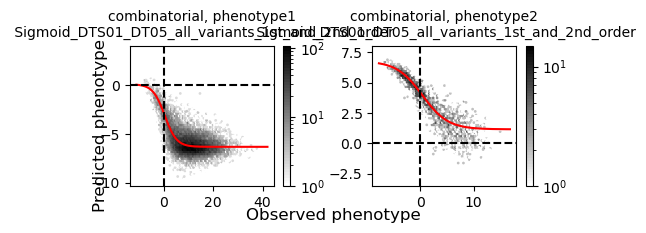

In [17]:
# all the results for run with all 3 doubles datasets
# N_max_inter = 1 everywhere

# only plotting for Sigmoid

transformations = ['Sigmoid']

fig, axs = plt.subplots(len(l2_regularisation_factor_values), len(phenotypes),
                        figsize=(5, 2), squeeze=False)
fig.tight_layout()
fig.subplots_adjust(hspace=0.4)

fig.supxlabel('Observed phenotype')
fig.supylabel('Predicted phenotype')

    

for i in range(len(phenotypes)):
    
    # plotting for each dataset
    curr_phenotype = phenotypes[i] # eLife is 1, NNK (C-term) is 2, Nicking (N-term) is 3

    curr_transformation = 'Sigmoid'
    
    for j in range(len(l2_regularisation_factor_values)):
        print(j)
        curr_l2_regularisation_factor_value = l2_regularisation_factor_values[j]
        
        curr_key = 'Sigmoid_DTS01_DT05_all_variants_1st_and_2nd_order'
        
        # separating input table by phenotype/dataset into 3
    
        curr_predictions_all = predictions[curr_key]
        curr_predictions_selected = curr_predictions_all[curr_predictions_all['phenotype'] == curr_phenotype]
        #curr_predictions_2 = curr_predictions_all[curr_predictions_all['phenotype'] == '2']
        #curr_predictions_3 = curr_predictions_all[curr_predictions_all['phenotype'] == '3']
    
        plot_observed_phenotype_vs_additivetrait_multiplot(curr_predictions_selected,
                                run_key=curr_key,
                                axis=axs[j, i], phenotype=curr_phenotype,
                                 Title = 'combinatorial, phenotype' + curr_phenotype + '\n ' + curr_key)
        
plt.savefig('./figures/20240718_mochi_observed_phenotype_vs_additivetrait_Nucleation_DTS01_DTS01.pdf',
            bbox_inches = 'tight')

    


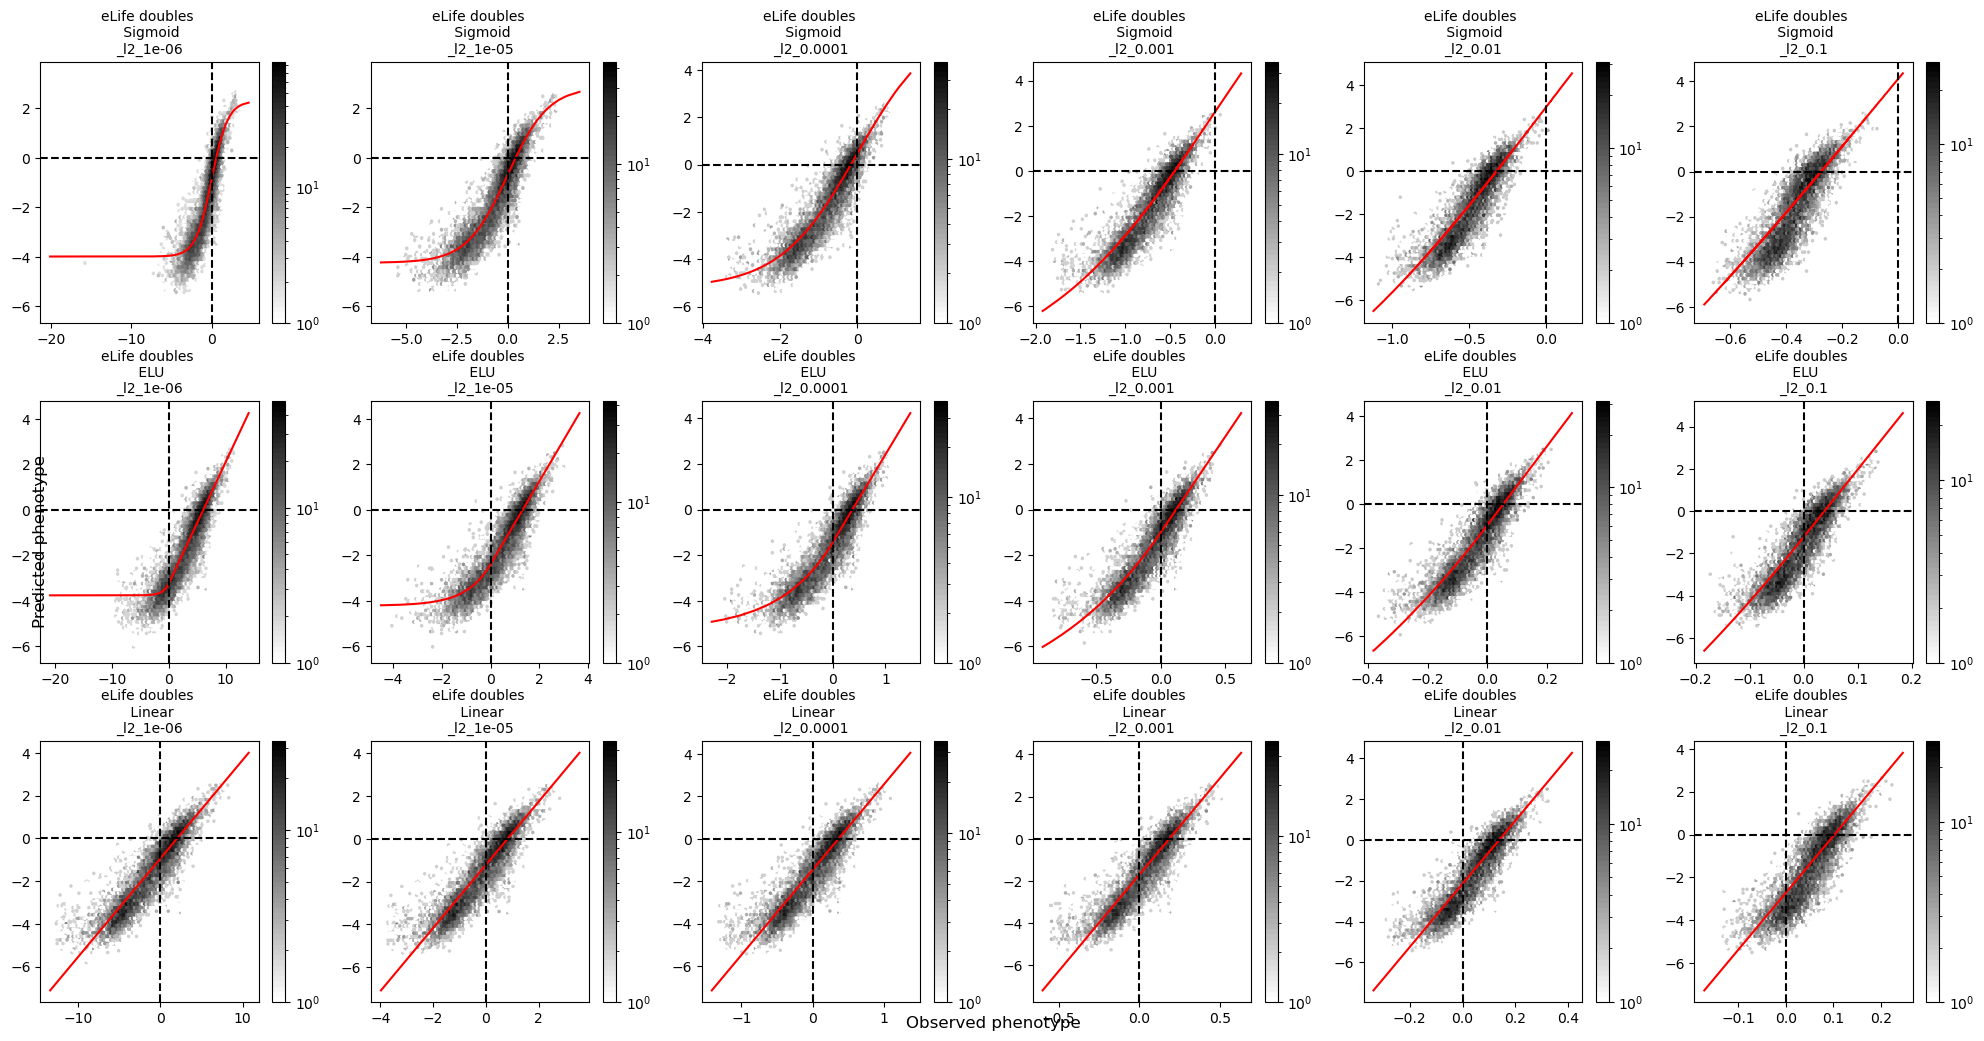

In [43]:
# all the results for run with all 3 doubles datasets
# N_max_inter = 1 everywhere

fig, axs = plt.subplots(len(transformations),len(l2_regularisation_factor_values), 
                        figsize=(20, 10))
fig.tight_layout()
fig.subplots_adjust(hspace=0.3)


fig.supxlabel('Observed phenotype')
fig.supylabel('Predicted phenotype')

# plotting for eLife dataset
curr_phenotype = '1' # eLife

for i in range(len(transformations)):
    curr_transformation = transformations[i]
    
    for j in range(len(l2_regularisation_factor_values)):
        curr_l2_regularisation_factor_value = l2_regularisation_factor_values[j]
        
        # separating input table by phenotype/dataset into 3
    
        curr_predictions_all = predictions[curr_transformation + '_all_3_doubles_datasets_1st_order_l2_' + curr_l2_regularisation_factor_value]
        curr_predictions_eLife = curr_predictions_all[curr_predictions_all['phenotype'] == '1']
        #curr_predictions_2 = curr_predictions_all[curr_predictions_all['phenotype'] == '2']
        #curr_predictions_3 = curr_predictions_all[curr_predictions_all['phenotype'] == '3']
    
        plot_observed_phenotype_vs_additivetrait_multiplot(curr_predictions_eLife,
                                run_key=curr_transformation + '_all_3_doubles_datasets_1st_order_l2_' + curr_l2_regularisation_factor_value,
                                axis=axs[i, j], phenotype=curr_phenotype,
                                 Title = 'eLife doubles \n ' + curr_transformation + '\n' + '_l2_' + curr_l2_regularisation_factor_value)
        
plt.savefig('./figures/20240212_mochi_observed_phenotype_vs_additivetrait_Nucleation_all_3_doubles_1st_ord_terms_allowed_eLife_l2_testing.pdf',
            bbox_inches = 'tight')

    


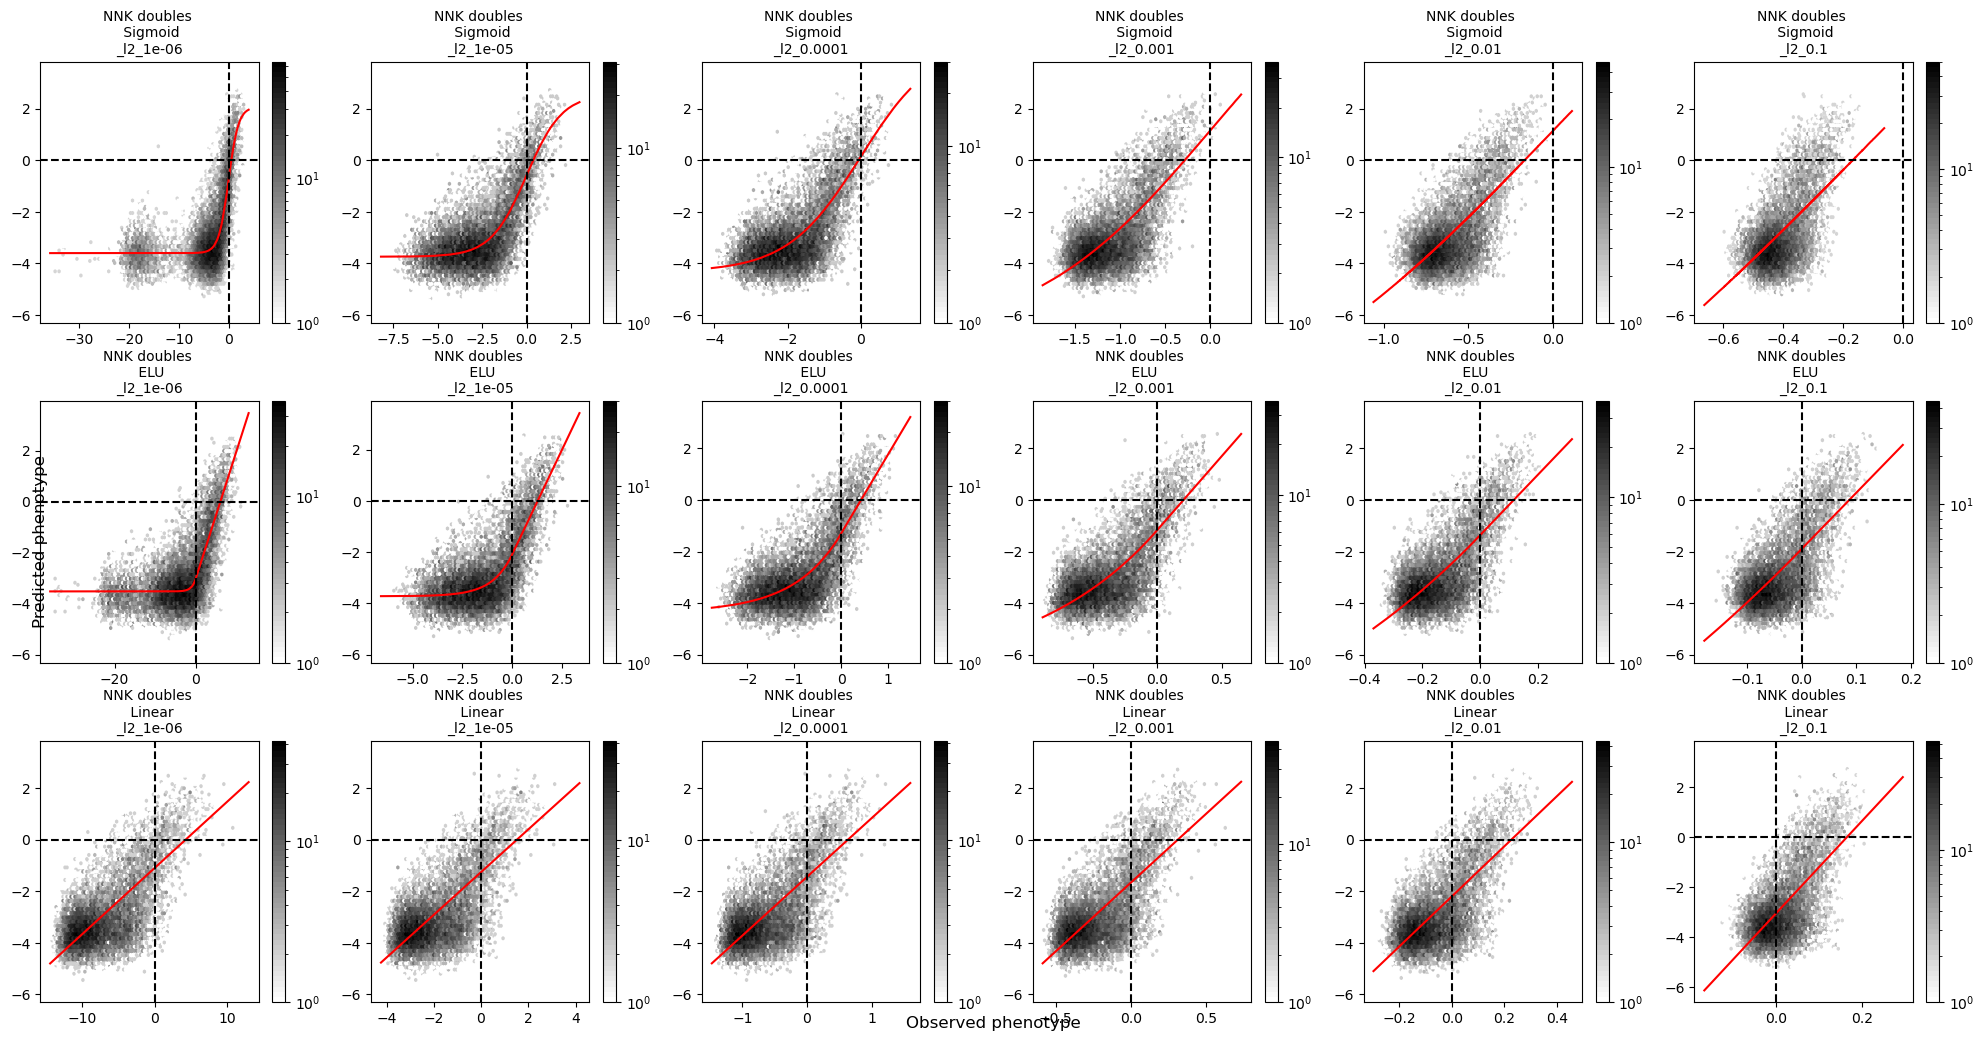

In [44]:
# all the results for run with all 3 doubles datasets
# N_max_inter = 1 everywhere

fig, axs = plt.subplots(len(transformations),len(l2_regularisation_factor_values), 
                        figsize=(20, 10))
fig.tight_layout()
fig.subplots_adjust(hspace=0.3)


fig.supxlabel('Observed phenotype')
fig.supylabel('Predicted phenotype')

# plotting for eLife dataset
curr_phenotype = '2' # NNK

for i in range(len(transformations)):
    curr_transformation = transformations[i]
    
    for j in range(len(l2_regularisation_factor_values)):
        curr_l2_regularisation_factor_value = l2_regularisation_factor_values[j]
        
        # separating input table by phenotype/dataset into 3
    
        curr_predictions_all = predictions[curr_transformation + '_all_3_doubles_datasets_1st_order_l2_' + curr_l2_regularisation_factor_value]
        #curr_predictions_eLife = curr_predictions_all[curr_predictions_all['phenotype'] == '1']
        curr_predictions_NNK = curr_predictions_all[curr_predictions_all['phenotype'] == '2']
        #curr_predictions_3 = curr_predictions_all[curr_predictions_all['phenotype'] == '3']
    
        plot_observed_phenotype_vs_additivetrait_multiplot(curr_predictions_NNK,
                                run_key=curr_transformation + '_all_3_doubles_datasets_1st_order_l2_' + curr_l2_regularisation_factor_value,
                                axis=axs[i, j], phenotype=curr_phenotype,
                                 Title = 'NNK doubles \n ' + curr_transformation + '\n' + '_l2_' + curr_l2_regularisation_factor_value)
        
plt.savefig('./figures/20240212_mochi_observed_phenotype_vs_additivetrait_Nucleation_all_3_doubles_1st_ord_terms_allowed_NNK_l2_testing.pdf',
            bbox_inches = 'tight')

    


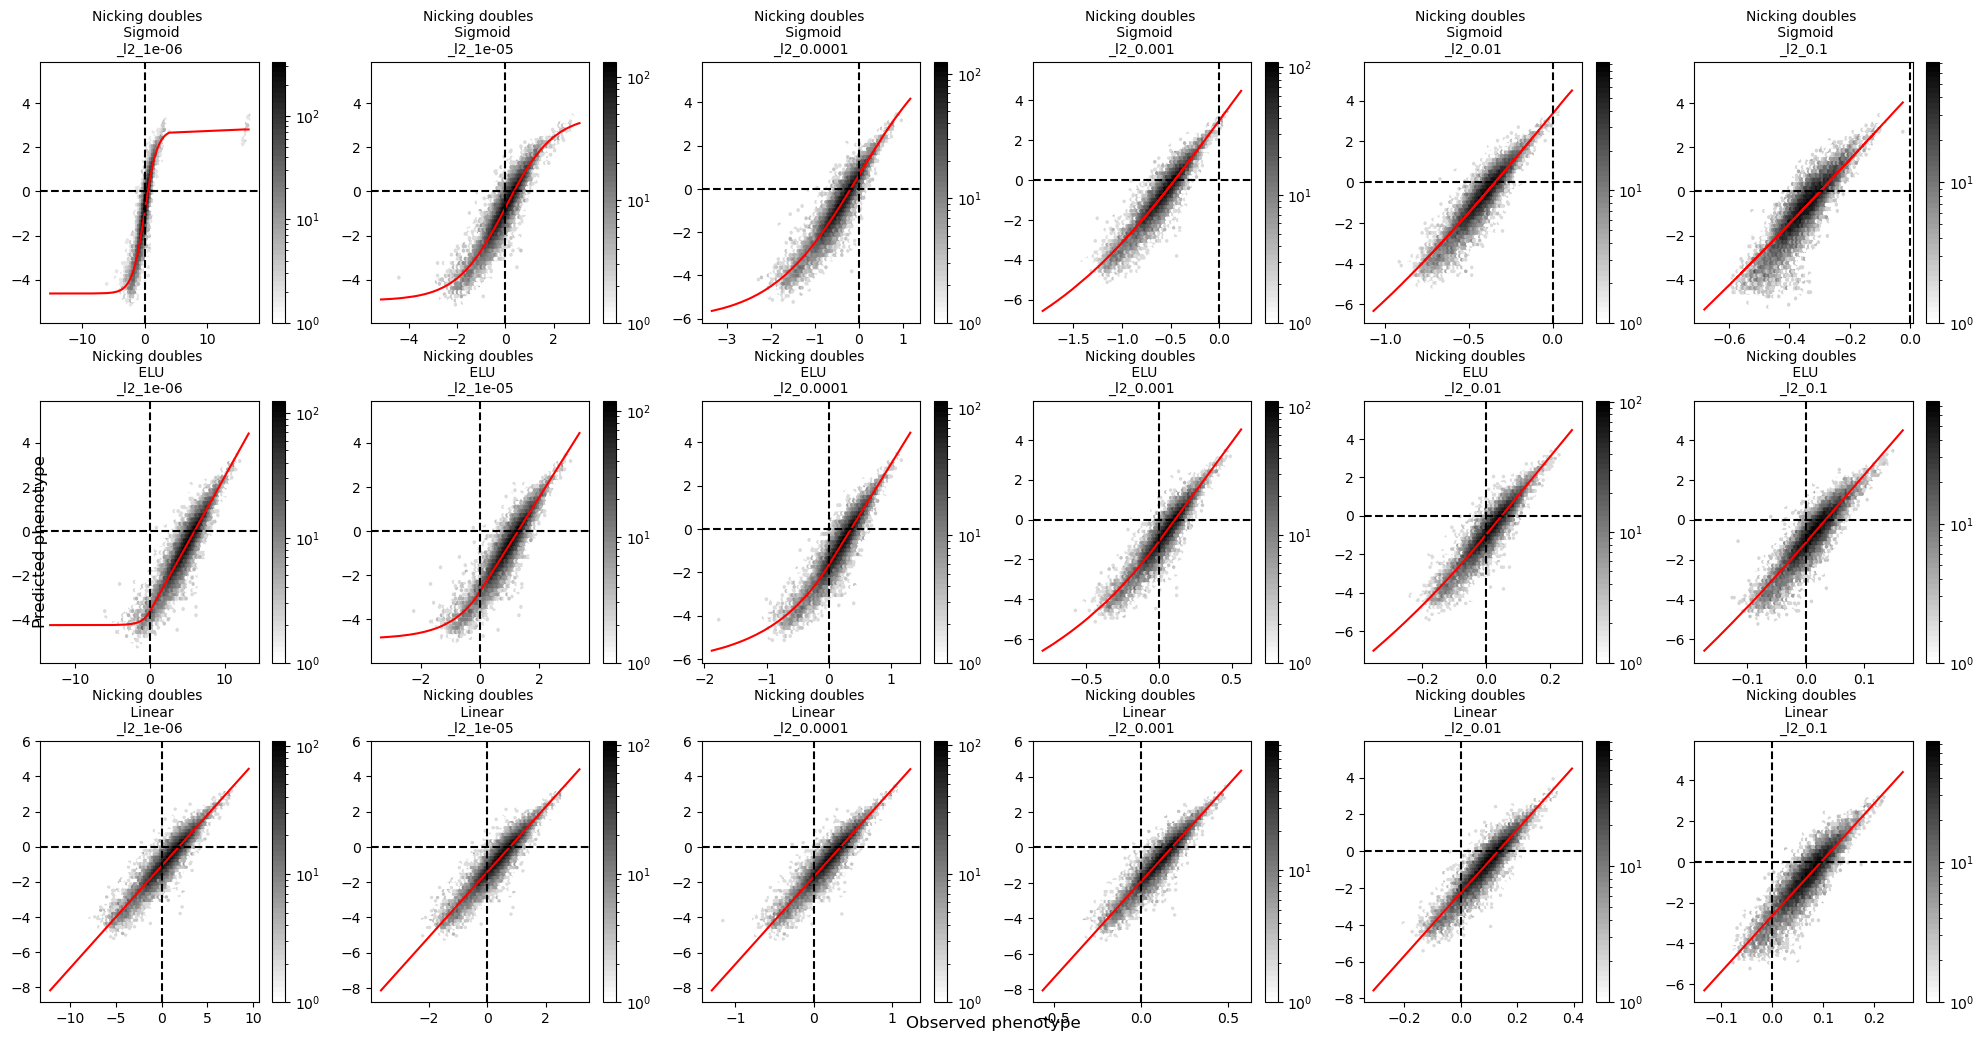

In [45]:
# all the results for run with all 3 doubles datasets
# N_max_inter = 1 everywhere

fig, axs = plt.subplots(len(transformations),len(l2_regularisation_factor_values), 
                        figsize=(20, 10))
fig.tight_layout()
fig.subplots_adjust(hspace=0.3)


fig.supxlabel('Observed phenotype')
fig.supylabel('Predicted phenotype')

# plotting for eLife dataset
curr_phenotype = '3' # Nicking

for i in range(len(transformations)):
    curr_transformation = transformations[i]
    
    for j in range(len(l2_regularisation_factor_values)):
        curr_l2_regularisation_factor_value = l2_regularisation_factor_values[j]
        
        # separating input table by phenotype/dataset into 3
    
        curr_predictions_all = predictions[curr_transformation + '_all_3_doubles_datasets_1st_order_l2_' + curr_l2_regularisation_factor_value]
        #curr_predictions_eLife = curr_predictions_all[curr_predictions_all['phenotype'] == '1']
        #curr_predictions_NNK = curr_predictions_all[curr_predictions_all['phenotype'] == '2']
        curr_predictions_Nicking = curr_predictions_all[curr_predictions_all['phenotype'] == '3']
    
        plot_observed_phenotype_vs_additivetrait_multiplot(curr_predictions_Nicking,
                                run_key=curr_transformation + '_all_3_doubles_datasets_1st_order_l2_' + curr_l2_regularisation_factor_value,
                                axis=axs[i, j], phenotype=curr_phenotype,
                                 Title = 'Nicking doubles \n ' + curr_transformation + '\n' + '_l2_' + curr_l2_regularisation_factor_value)
        
plt.savefig('./figures/20240212_mochi_observed_phenotype_vs_additivetrait_Nucleation_all_3_doubles_1st_ord_terms_allowed_Nicking_l2_testing.pdf',
            bbox_inches = 'tight')

    


# make residuals plots (see example in Andre's MS)

In [18]:
def plot_residuals_multiplot(
        #self,
        input_df,
        run_key, # Linear_not_dead; etc, the model run (transformation + file handle) 
        #output_path_prefix,
        phenotype, # phenotype value (str) from input_df['phenotype'] to plot stuff for
        axis,
        transformation = None,
        Title = None,
        folds = None,
        RT = None):
        """
        Plot observed phenoypte versus additive trait (1-dimensional additive traits only).

        :param input_df: Input DataFrame with all predictions (required).
        :param output_path_prefix: Output file path (required).
        :param folds: list of cross-validation folds (default:None i.e. all).
        :param RT: R=gas constant (in kcal/K/mol) * T=Temperature (in K) (optional).
        :returns: Nothing.
        """ 
        #Set folds if not supplied
        if folds==None:
            folds = [i+1 for i in range(mochi_tasks[run_key].data.k_folds)]

        #Set RT if not supplied
        if RT==None:
            RT = 1

        fold = folds[0] # it is 1 now
        observed_phenotype_col = 'fitness'

        #Plot performance for all 1-dimensional phenotypes
        
        i = int(phenotype) - 1 # phenotype counter, for phenotype 1 should be 0, and so on
                
        if len(mochi_tasks[run_key].data.model_design.loc[i,'trait'])==1:
            predicted_phenotype_col = 'fold_'+str(fold)
            additive_trait_col = predicted_phenotype_col+'_additive_trait0' # this will be 'fold_1_additive_trait0'
            # sort by fold_1_additive_trait0
            plot_df_sort = input_df.loc[input_df.phenotype==str(i+1),:].sort_values(additive_trait_col)
            plot_df_sort.reset_index(drop = True, inplace = True)
                
            
            #Convert units
            plot_df_sort[additive_trait_col+"_kcal/mol"] = plot_df_sort[additive_trait_col]*RT
            additive_trait_col = additive_trait_col+"_kcal/mol"
            residuals_col = 'residual_obs_vs_pred'
            #fig, ax = plt.subplots()
            n_bin = 50
            cmap = LinearSegmentedColormap.from_list('whiteblack', ['white', 'black'], N=n_bin)
            
            z = axis.hexbin(
                    x = additive_trait_col,
                    y = residuals_col,
                    data = plot_df_sort.loc[plot_df_sort.phenotype==str(i+1),:], gridsize = 100, cmap = cmap, bins = 'log')
            axis.plot(
                    plot_df_sort.loc[plot_df_sort.phenotype==str(i+1),additive_trait_col], 
                    plot_df_sort.loc[plot_df_sort.phenotype==str(i+1),predicted_phenotype_col], mfc='none', 
                    linestyle = "-", color = 'red'
                )
            #Color scale
            plt.colorbar(z, ax=axis)
            #Guides
            axis.axhline(y = 0, color = 'black', linestyle = '--')
            axis.axvline(x = 0, color = 'black', linestyle = '--')
                
            #Labels
            #ax.set_title(mochi_tasks[run_key].data.phenotype_names[int(i)])
            axis.set_title(Title, fontsize = 10)
            if transformation != None:
                axis.set_ylabel(str(transformation) + '\n transformation', size = 14)
            #axis.set_xlabel('Additive trait (-dEa)', size = 14)
            #Save
            #plt.savefig(output_path_prefix+self.task.data.phenotype_names[int(i)]+".pdf")

In [19]:
mochi_tasks

{'Sigmoid_DTS01_DT05_all_variants_1st_and_2nd_order': <pymochi.models.MochiTask at 0x14faf4fe4700>}

In [20]:
def plot_residuals_multiplot_with_smoothed_average(
        #self,
        input_df,
        run_key, # Linear_not_dead; etc, the model run (transformation + file handle) 
        #output_path_prefix,
        phenotype, # phenotype value (str) from input_df['phenotype'] to plot stuff for
        axis,
        transformation = None,
        Title = None,
        folds = None,
        RT = None):
        """
        Plot observed phenoypte versus additive trait (1-dimensional additive traits only).

        :param input_df: Input DataFrame with all predictions (required).
        :param output_path_prefix: Output file path (required).
        :param folds: list of cross-validation folds (default:None i.e. all).
        :param RT: R=gas constant (in kcal/K/mol) * T=Temperature (in K) (optional).
        :returns: Nothing.
        """ 
        #Set folds if not supplied
        if folds==None:
            folds = [i+1 for i in range(mochi_tasks[run_key].data.k_folds)]

        #Set RT if not supplied
        if RT==None:
            RT = 1

        fold = folds[0] # it is 1 now
        observed_phenotype_col = 'fitness'

        #Plot performance for all 1-dimensional phenotypes
        
        i = int(phenotype) - 1 # phenotype counter, for phenotype 1 should be 0, and so on
                
        if len(mochi_tasks[run_key].data.model_design.loc[i,'trait'])==1:
            predicted_phenotype_col = 'fold_'+str(fold)
            additive_trait_col = predicted_phenotype_col+'_additive_trait0' # this will be 'fold_1_additive_trait0'
            # sort by fold_1_additive_trait0
            plot_df_sort = input_df.loc[input_df.phenotype==str(i+1),:].sort_values(additive_trait_col)
            plot_df_sort.reset_index(drop = True, inplace = True)
                
            
            #Convert units
            plot_df_sort[additive_trait_col+"_kcal/mol"] = plot_df_sort[additive_trait_col]*RT
            additive_trait_col = additive_trait_col+"_kcal/mol"
            residuals_col = 'residual_pred_vs_obs'
            #fig, ax = plt.subplots()
            n_bin = 50
            cmap = LinearSegmentedColormap.from_list('whiteblack', ['white', 'black'], N=n_bin)
            
            z = axis.hexbin(
                    x = additive_trait_col,
                    y = residuals_col,
                    data = plot_df_sort.loc[plot_df_sort.phenotype==str(i+1),:], gridsize = 100, cmap = cmap, bins = 'log')
            
            # range of values along X axis (additive trait col)
            x_range = [np.min(plot_df_sort.loc[plot_df_sort.phenotype==str(i+1),additive_trait_col]), 
                  np.max(plot_df_sort.loc[plot_df_sort.phenotype==str(i+1),additive_trait_col])]
            
            # iteratively pass all N=50 bins along x axis
            N_x_bins = 50
            smoothed_mean_vec = [0]*N_x_bins # should be of N_x_bins length 
            x_positions_for_smoothed_mean_vec = []
            
            for j in range(N_x_bins):
                #print(j)
                step = (x_range[1] - x_range[0])/N_x_bins
                #print('step:', step)
                curr_min = x_range[0] + step*j
                curr_max = x_range[0] + step*(j+1)

                #print('curr_min:',curr_min)
                #print('curr_max:',curr_max)

                curr_x_vector = plot_df_sort.loc[plot_df_sort.phenotype==str(i+1),additive_trait_col]
                # observed NS values (y axis)
                curr_y_vector = plot_df_sort.loc[plot_df_sort.phenotype==str(i+1),residuals_col]

                #print('curr_x_vector:',curr_x_vector)
                #print('curr_y_vector:',curr_y_vector)

                # indices of element of curr_x_vector that are in [curr_min,curr_max] bounds
                idx_bin = [k for k,v in enumerate(curr_x_vector) if (v >= curr_min) & (v < curr_max)]

                #print('idx_bin', idx_bin)

                # if there are any values of relevant observed_phenotype_col vector within this range, take their average and overwrite the current 0 in smoothed_mean_vec
                if len(idx_bin) > 0:
                    curr_y_values_in_bounds = [curr_y_vector[m] for m in idx_bin]
                    curr_average = np.mean(curr_y_values_in_bounds)
                    smoothed_mean_vec[j] = curr_average
                    
                x_positions_for_smoothed_mean_vec.append(curr_min+step/2)
            
            
            axis.plot(
                    x_positions_for_smoothed_mean_vec, 
                    smoothed_mean_vec, mfc='none', 
                    linestyle = "-", color = 'red'
                )
            #Color scale
            plt.colorbar(z, ax=axis)
            #Guides
            axis.axhline(y = 0, color = 'black', linestyle = '--')
            axis.axvline(x = 0, color = 'black', linestyle = '--')
                
            #Labels
            #ax.set_title(mochi_tasks[run_key].data.phenotype_names[int(i)])
            axis.set_title(Title, fontsize = 10)
            if transformation != None:
                axis.set_ylabel(str(transformation) + '\n transformation', size = 14)
            #axis.set_xlabel('Additive trait (-dEa)', size = 14)
            #Save
            #plt.savefig(output_path_prefix+self.task.data.phenotype_names[int(i)]+".pdf")

In [21]:
%%bash

pwd

/lustre/scratch126/gengen/projects/amyloid_beta_epistasis/DTS_joint_analysis/selected_DTS_datasets_analysis/DTS01_DTS05


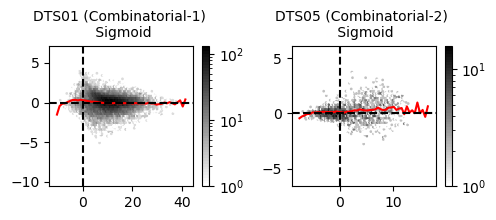

In [22]:
# all the results for run with all 3 doubles datasets
# N_max_inter = 1 everywhere

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5,2))

fig.tight_layout()
fig.subplots_adjust(hspace=0.4)

#fig.supxlabel('Observed phenotype')
#fig.supylabel('Predicted phenotype')

curr_transformation = 'Sigmoid'

curr_phenotype = '1' # DTS01 aka Combinatorial-1

curr_predictions_all = predictions['Sigmoid_DTS01_DT05_all_variants_1st_and_2nd_order']

curr_predictions = curr_predictions_all[curr_predictions_all['phenotype'] == curr_phenotype]

plot_residuals_multiplot_with_smoothed_average(curr_predictions,
                                run_key='Sigmoid_DTS01_DT05_all_variants_1st_and_2nd_order',
                                axis=ax1, phenotype=curr_phenotype,
                                 Title = 'DTS01 (Combinatorial-1) \n ' + curr_transformation)
        
    
curr_phenotype = '2' # DTS05 aka Combinatorial-2

    
curr_predictions = curr_predictions_all[curr_predictions_all['phenotype'] == curr_phenotype]
plot_residuals_multiplot_with_smoothed_average(curr_predictions,
                                run_key='Sigmoid_DTS01_DT05_all_variants_1st_and_2nd_order',
                                axis=ax2, phenotype=curr_phenotype,
                                 Title = 'DTS05 (Combinatorial-2) \n ' + curr_transformation)

    

plt.savefig('./figures/20240718_mochi_residuals_DTS01_DTS05.pdf',
           bbox_inches = 'tight')

    


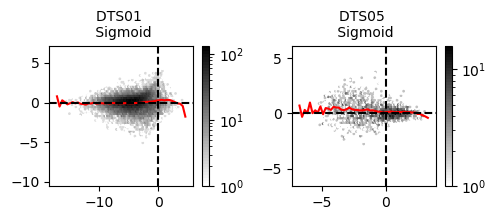

In [33]:
# all the results for run with all 3 doubles datasets
# N_max_inter = 1 everywhere

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5,2))

fig.tight_layout()
fig.subplots_adjust(hspace=0.4)

#fig.supxlabel('Observed phenotype')
#fig.supylabel('Predicted phenotype')

# plotting for DTS01 dataset
curr_phenotype = '1' # DTS01

curr_predictions_all = predictions['Sigmoid_DTS01_DT05_all_variants_1st_and_2nd_order']

curr_predictions = curr_predictions_all[curr_predictions_all['phenotype'] == curr_phenotype]

plot_residuals_multiplot_with_smoothed_average(curr_predictions,
                                run_key='Sigmoid_DTS01_DT05_all_variants_1st_and_2nd_order',
                                axis=ax1, phenotype=curr_phenotype,
                                 Title = 'DTS01 \n ' + curr_transformation)
        
    
# plotting for DTS01 dataset
curr_phenotype = '2' # DTS05

    
curr_predictions = curr_predictions_all[curr_predictions_all['phenotype'] == curr_phenotype]
plot_residuals_multiplot_with_smoothed_average(curr_predictions,
                                run_key='Sigmoid_DTS01_DT05_all_variants_1st_and_2nd_order',
                                axis=ax2, phenotype=curr_phenotype,
                                 Title = 'DTS05 \n ' + curr_transformation)
   
    

plt.savefig('/lustre/scratch126/gengen/projects/amyloid_beta_epistasis/DTS_joint_analysis/selected_DTS_datasets_analysis/DTS01_DTS05/figures/20240510_mochi_residuals_DTS01_DTS05_model.pdf',
           bbox_inches = 'tight')

    


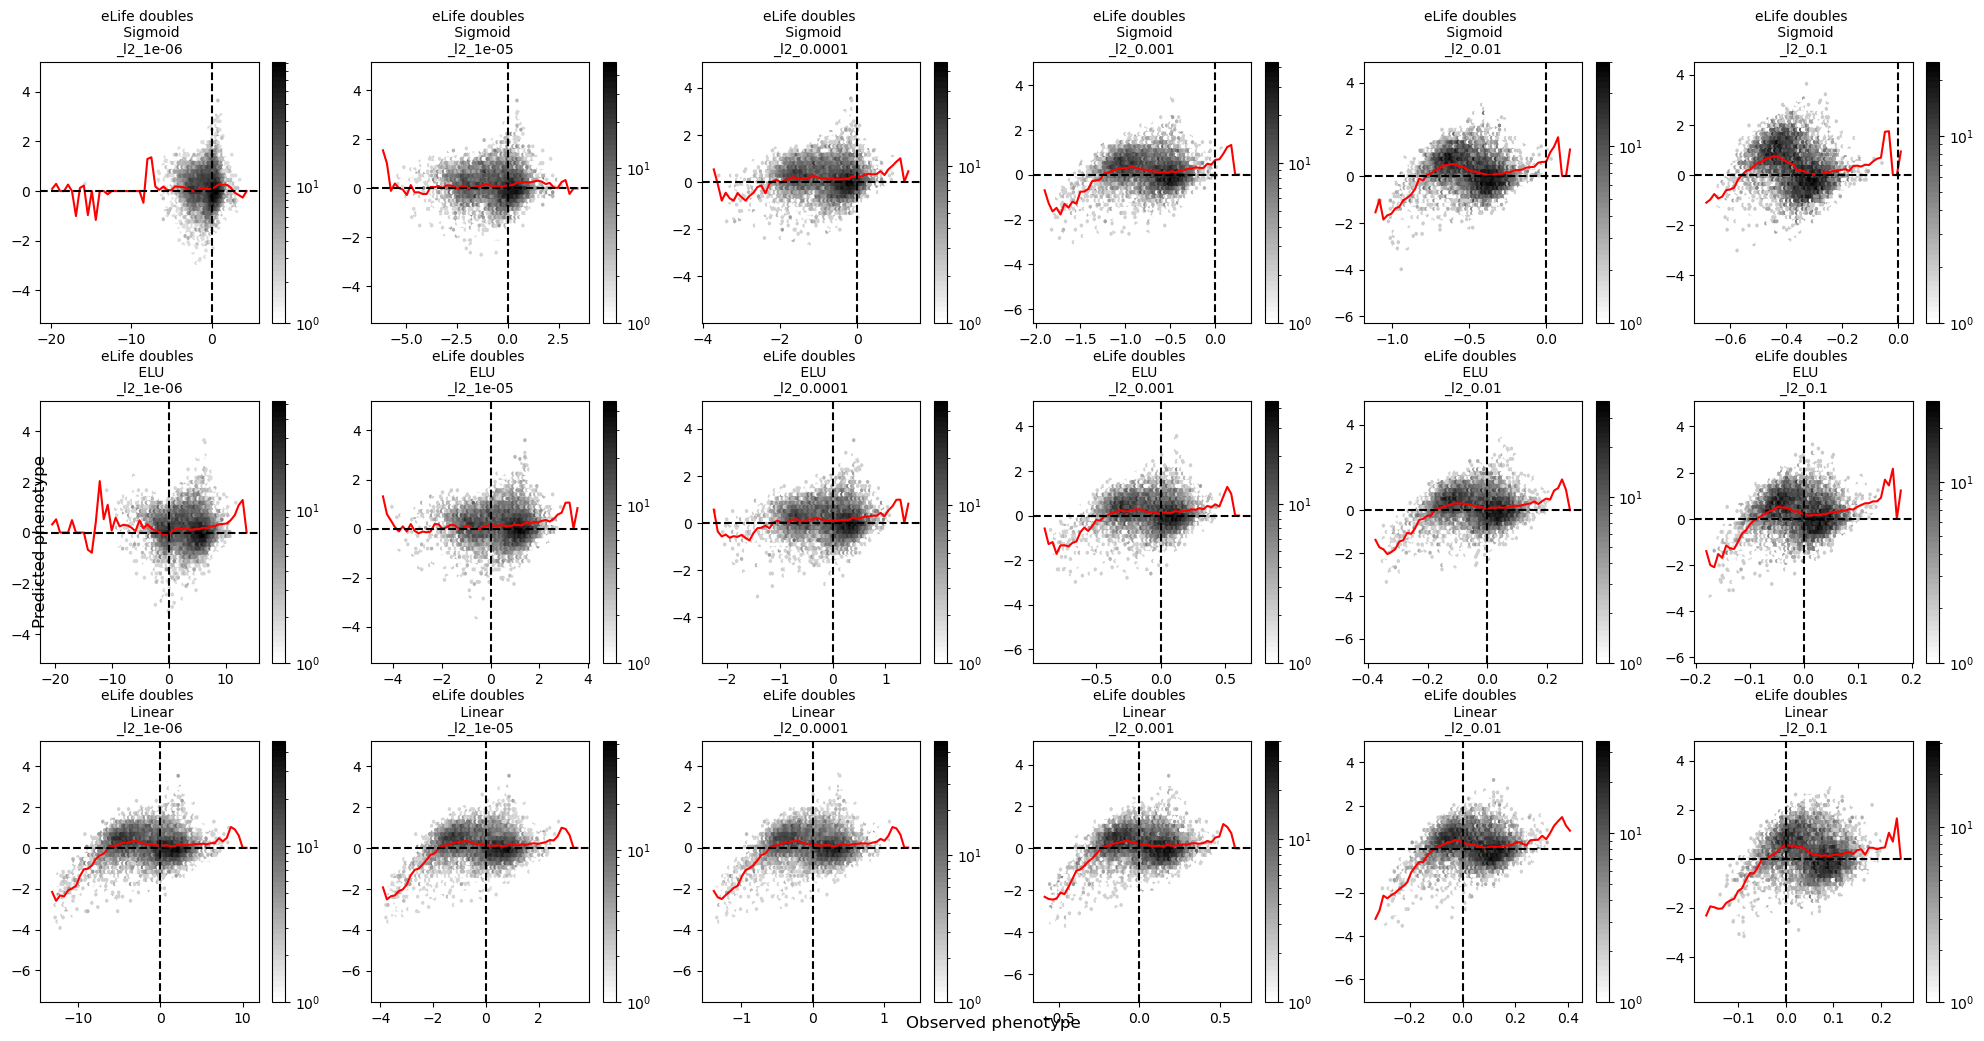

In [48]:
# all the results for run with all 3 doubles datasets
# N_max_inter = 1 everywhere

fig, axs = plt.subplots(len(transformations),len(l2_regularisation_factor_values), 
                        figsize=(20, 10))
fig.tight_layout()
fig.subplots_adjust(hspace=0.3)


fig.supxlabel('Observed phenotype')
fig.supylabel('Predicted phenotype')

# plotting for eLife dataset
curr_phenotype = '1' # eLife

for i in range(len(transformations)):
    curr_transformation = transformations[i]
    
    for j in range(len(l2_regularisation_factor_values)):
        curr_l2_regularisation_factor_value = l2_regularisation_factor_values[j]
        
        # separating input table by phenotype/dataset into 3
    
        curr_predictions_all = predictions[curr_transformation + '_all_3_doubles_datasets_1st_order_l2_' + curr_l2_regularisation_factor_value]
        curr_predictions_eLife = curr_predictions_all[curr_predictions_all['phenotype'] == '1']
        #curr_predictions_2 = curr_predictions_all[curr_predictions_all['phenotype'] == '2']
        #curr_predictions_3 = curr_predictions_all[curr_predictions_all['phenotype'] == '3']
    
        plot_residuals_multiplot_with_smoothed_average(curr_predictions_eLife,
                                run_key=curr_transformation + '_all_3_doubles_datasets_1st_order_l2_' + curr_l2_regularisation_factor_value,
                                axis=axs[i, j], phenotype=curr_phenotype,
                                 Title = 'eLife doubles \n ' + curr_transformation + '\n' + '_l2_' + curr_l2_regularisation_factor_value)
        
plt.savefig('./figures/20240212_mochi_residuals_pred_vs_obs_w_avg_mean_Nucleation_all_3_doubles_1st_ord_terms_allowed_eLife_l2_testing.pdf',
            bbox_inches = 'tight')

    


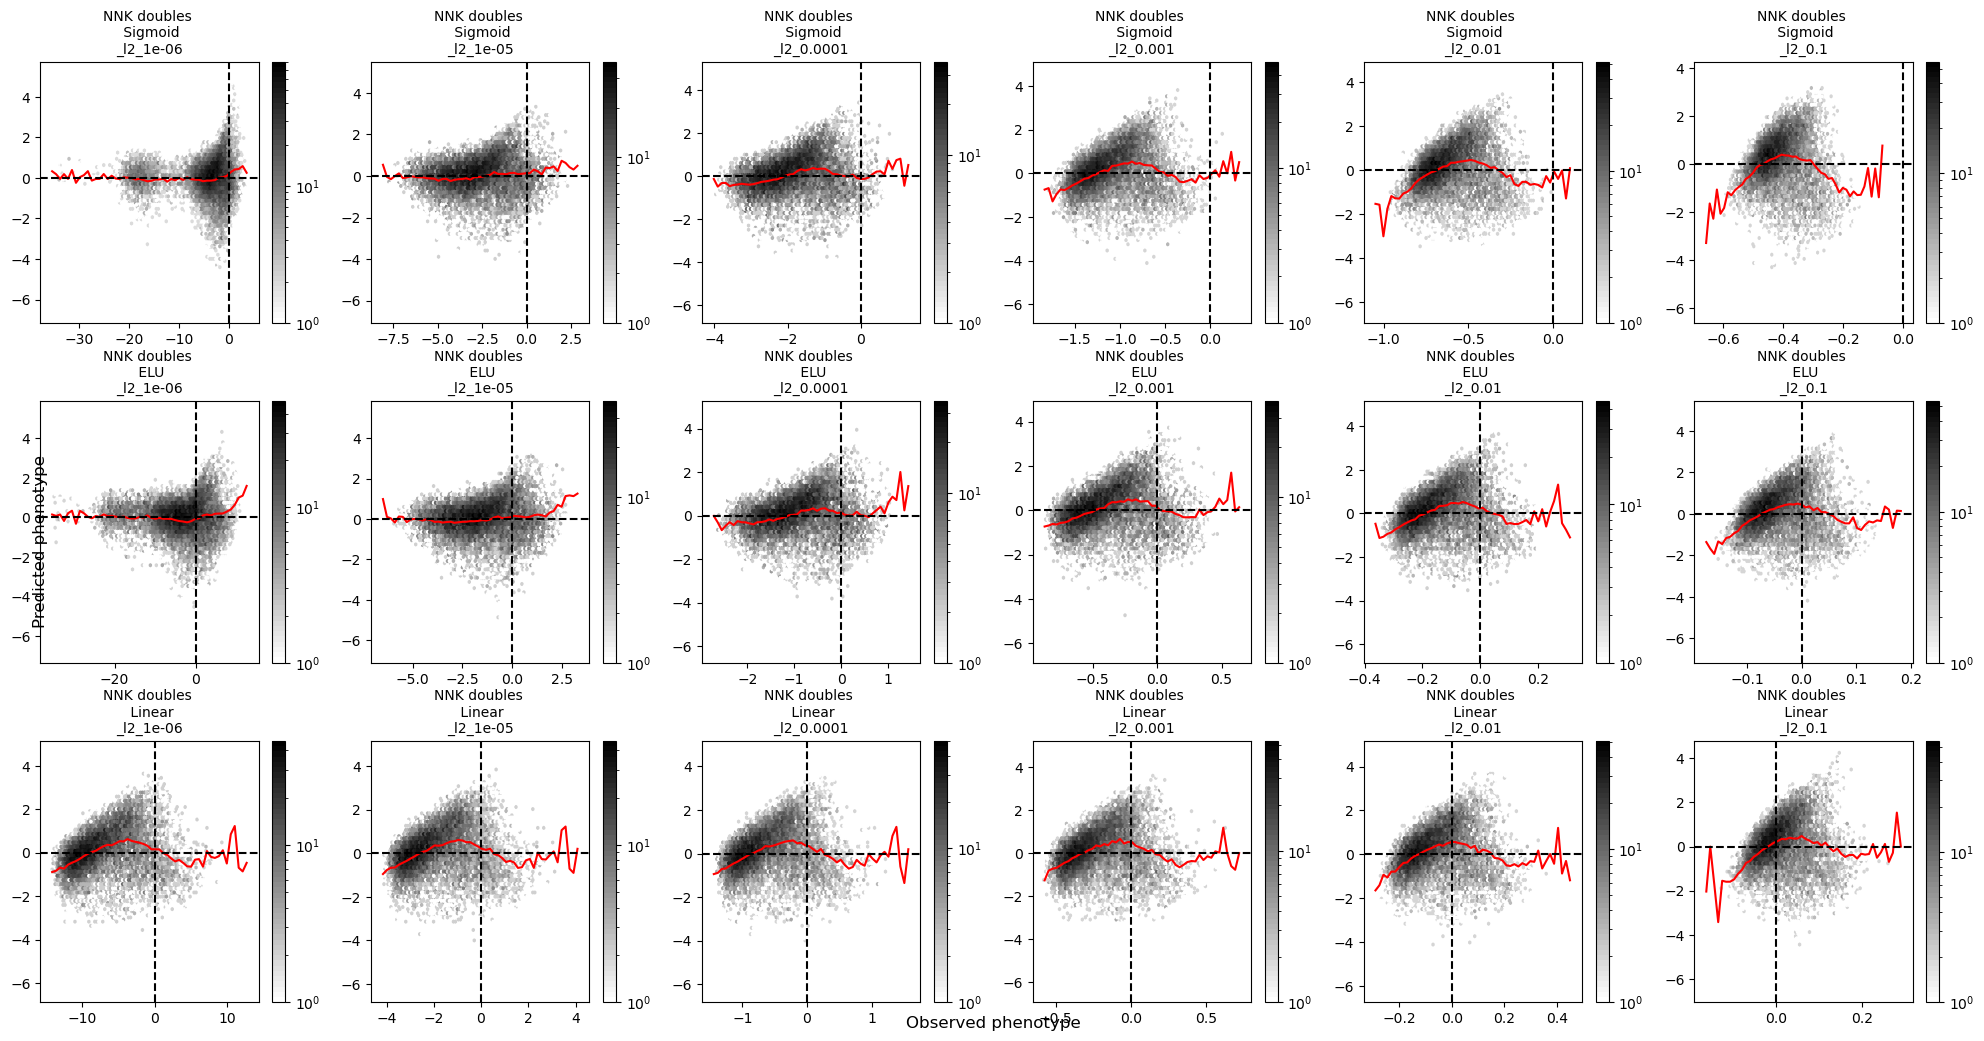

In [49]:
# all the results for run with all 3 doubles datasets
# N_max_inter = 1 everywhere

fig, axs = plt.subplots(len(transformations),len(l2_regularisation_factor_values), 
                        figsize=(20, 10))
fig.tight_layout()
fig.subplots_adjust(hspace=0.3)


fig.supxlabel('Observed phenotype')
fig.supylabel('Predicted phenotype')

# plotting for eLife dataset
curr_phenotype = '2' # NNK

for i in range(len(transformations)):
    curr_transformation = transformations[i]
    
    for j in range(len(l2_regularisation_factor_values)):
        curr_l2_regularisation_factor_value = l2_regularisation_factor_values[j]
        
        # separating input table by phenotype/dataset into 3
    
        curr_predictions_all = predictions[curr_transformation + '_all_3_doubles_datasets_1st_order_l2_' + curr_l2_regularisation_factor_value]
        #curr_predictions_eLife = curr_predictions_all[curr_predictions_all['phenotype'] == '1']
        curr_predictions_NNK = curr_predictions_all[curr_predictions_all['phenotype'] == '2']
        #curr_predictions_3 = curr_predictions_all[curr_predictions_all['phenotype'] == '3']
    
        plot_residuals_multiplot_with_smoothed_average(curr_predictions_NNK,
                                run_key=curr_transformation + '_all_3_doubles_datasets_1st_order_l2_' + curr_l2_regularisation_factor_value,
                                axis=axs[i, j], phenotype=curr_phenotype,
                                 Title = 'NNK doubles \n ' + curr_transformation + '\n' + '_l2_' + curr_l2_regularisation_factor_value)
        
plt.savefig('./figures/20240212_mochi_residuals_pred_vs_obs_w_avg_mean_Nucleation_all_3_doubles_1st_ord_terms_allowed_NNK_l2_testing.pdf',
            bbox_inches = 'tight')

    


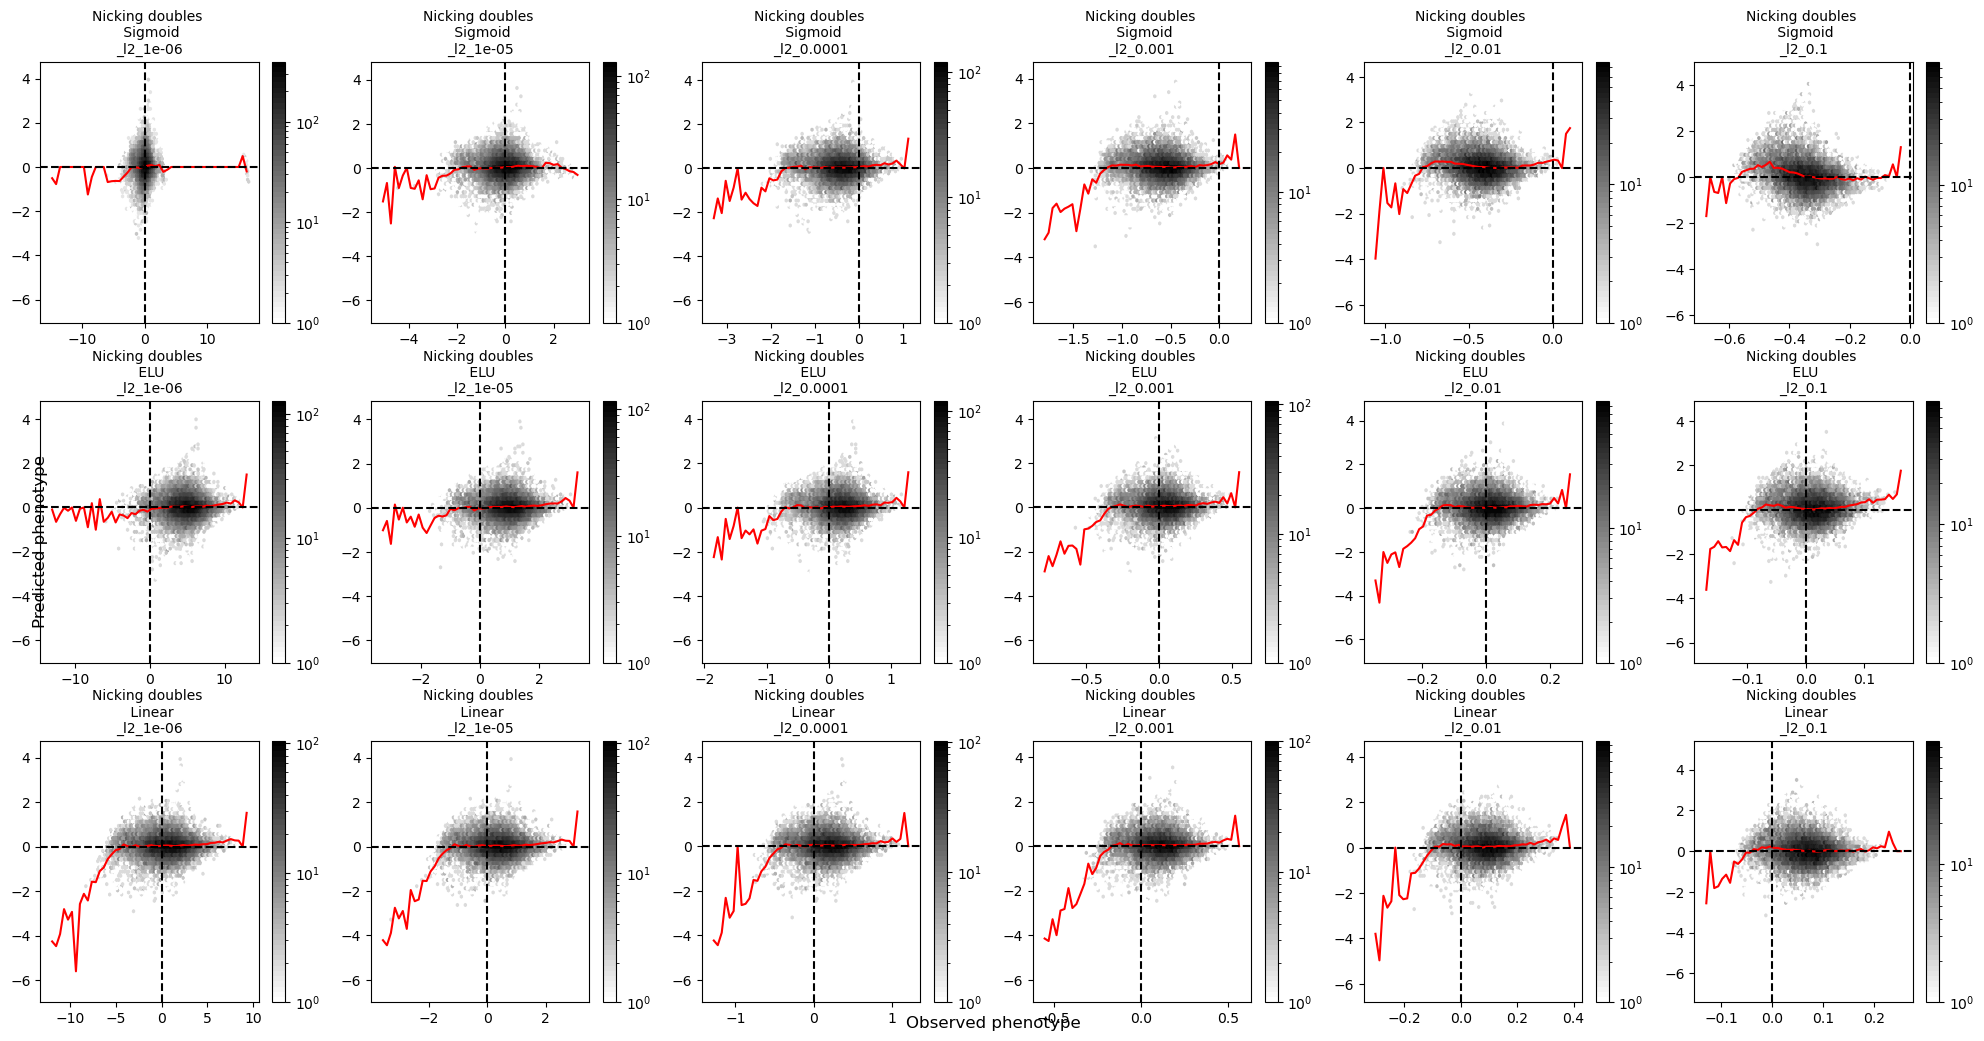

In [50]:
# all the results for run with all 3 doubles datasets
# N_max_inter = 1 everywhere

fig, axs = plt.subplots(len(transformations),len(l2_regularisation_factor_values), 
                        figsize=(20, 10))
fig.tight_layout()
fig.subplots_adjust(hspace=0.3)


fig.supxlabel('Observed phenotype')
fig.supylabel('Predicted phenotype')

# plotting for eLife dataset
curr_phenotype = '3' # Nicking

for i in range(len(transformations)):
    curr_transformation = transformations[i]
    
    for j in range(len(l2_regularisation_factor_values)):
        curr_l2_regularisation_factor_value = l2_regularisation_factor_values[j]
        
        # separating input table by phenotype/dataset into 3
    
        curr_predictions_all = predictions[curr_transformation + '_all_3_doubles_datasets_1st_order_l2_' + curr_l2_regularisation_factor_value]
        #curr_predictions_eLife = curr_predictions_all[curr_predictions_all['phenotype'] == '1']
        #curr_predictions_NNK = curr_predictions_all[curr_predictions_all['phenotype'] == '2']
        curr_predictions_Nicking = curr_predictions_all[curr_predictions_all['phenotype'] == '3']
    
        plot_residuals_multiplot_with_smoothed_average(curr_predictions_Nicking,
                                run_key=curr_transformation + '_all_3_doubles_datasets_1st_order_l2_' + curr_l2_regularisation_factor_value,
                                axis=axs[i, j], phenotype=curr_phenotype,
                                 Title = 'Nicking doubles \n ' + curr_transformation + '\n' + '_l2_' + curr_l2_regularisation_factor_value)
        
plt.savefig('./figures/20240212_mochi_residuals_pred_vs_obs_w_avg_mean_Nucleation_all_3_doubles_1st_ord_terms_allowed_Nicking_l2_testing.pdf',
            bbox_inches = 'tight')

    


# make -dd(Ea) plots

In [29]:
# looking at weights heatmaps

# Looking at weights of trained models

In [5]:
l2_regularisation_factor_value = '1e-05'

In [6]:
results_dir

'/lustre/scratch126/gengen/projects/amyloid_beta_epistasis/DTS_joint_analysis/mochi_results/'

In [ ]:
20240220_max_terms_order_1_ELU_l2_regularization_factor_1e-05_all_DTS_datasets_all_variants

In [16]:
# here will look only at runs with all 8 DTS datasets
# only 1st order terms are allowed
# Sigmoid, ELU and Linear fits

weights_Nucleation = {}

for transformation in transformations: 
    print(transformation)
        
    curr_path = results_dir + '20240308_max_terms_order_2_' + transformation + '_l2_regularization_factor_' + l2_regularisation_factor_value + '_all_DTS_datasets_all_live_variants_and_subsampled_dead'       


    weights_Nucleation[transformation] = pd.read_csv(curr_path + '/weights/weights_Nucleation.txt',
                                sep='\t')


Sigmoid
ELU
Linear


In [17]:
weights_Nucleation['ELU']

id     id_ref    Pos Pos_ref    fold_1    fold_2    fold_3  \
0            WT         WT    NaN     NaN  1.753303  1.717119  1.702347   
1           A2F        A2F      2       2 -0.113858 -0.126105  0.270668   
2           A2I        A2I      2       2 -1.275292 -0.640346 -0.611362   
3           A2L        A2L      2       2 -0.289476 -0.665448 -0.812500   
4           A2M        A2M      2       2 -0.264691 -0.139799 -0.353397   
...         ...        ...    ...     ...       ...       ...       ...   
4612  A21L_V39L  A21L_V39L  21_39   21_39  0.387219  0.659716  0.140743   
4613   A2M_I41V   A2M_I41V   2_41    2_41 -0.400553 -0.291070  0.049302   
4614  H14M_V39F  H14M_V39F  14_39   14_39 -0.202158 -0.488551  0.235514   
4615  M35I_A42I  M35I_A42I  35_42   35_42 -0.067985 -0.223157  0.064726   
4616  Q15I_A21L  Q15I_A21L  15_21   15_21       NaN -0.049706 -0.028699   

        fold_4    fold_5    fold_6  ...    fold_9   fold_10   n      mean  \
0     1.874320  1.865011  1.813098  ...  1.850796  1.750168  10  1.777810   
1    -0.235129 -0.041820 -0.449095  ... -0.145044 -0.016152  10 -0.041391   
2    -0.811387 -0.782242 -0.708198  ... -1.051127 -0.764648  10 -0.777435   
3     0.080948 -0.265668 -1.037930  ... -0.872554 -0.973527  10 -0.627067   
4    -0.016438 -0.667263 -0.028263  ... -0.387793 -0.615356  10 -0.378838   
...        ...       ...       ...  ...       ...       ...  ..       ...   
4612  0.201663  0.324341  0.565021  ...  0.508290  0.418346  10  0.382290   
4613  0.049787  0.100237  0.008370  ... -0.064195  0.070636  10 -0.065978   
4614  0.181152 -0.365712 -0.341241  ...  0.176137  0.198880  10 -0.054659   
4615 -0.238523 -0.347372 -0.261449  ...  0.408060 -0.092390  10 -0.075762   
4616  0.122191  0.050333 -0.155614  ... -0.102568 -0.111543   9 -0.052332   

           std      ci95  trait_name  mean_kcal/mol std_kcal/mol  \
0     0.066440  0.260443  Nucleation       1.070350     0.040001   
1     0.232038  0.909587  Nucleation      -0.024920     0.139701   
2     0.235356  0.922594  Nucleation      -0.468063     0.141698   
3     0.357794  1.402553  Nucleation      -0.377533     0.215414   
4     0.264334  1.036190  Nucleation      -0.228084     0.159145   
...        ...       ...         ...            ...          ...   
4612  0.167671  0.657270  Nucleation       0.230162     0.100948   
4613  0.172408  0.675837  Nucleation      -0.039723     0.103800   
4614  0.274380  1.075568  Nucleation      -0.032908     0.165193   
4615  0.234282  0.918385  Nucleation      -0.045613     0.141052   
4616  0.089757  0.351846  Nucleation      -0.031507     0.054039   

      ci95_kcal/mol  
0          0.156803  
1          0.547627  
2          0.555458  
3          0.844422  
4          0.623850  
...             ...  
4612       0.395717  
4613       0.406895  
4614       0.647558  
4615       0.552924  
4616       0.211833  

[4617 rows x 22 columns]

In [25]:
# first let's look at the first order terms just out of curiosity

In [26]:
l2_regularisation_factor_values = ['1e-05']

In [27]:
# table of all possible 20 aa in all possible Ab (42) positions

AB_WT = "DAEFRHDSGYEVHHQKLVFFAEDVGSNKGAIIGLMVGGVVIA"
all_aa = ["G","A","V","L","M","I","F","Y","W","K","R","D","E","S","T","C","N","Q","H", "P", "*"]

ddE_df_mean_kcalmol = {}

for l2_regularisation_factor_value in l2_regularisation_factor_values:
    for transformation in transformations:
        #print(transformation)
        ddE_df_mean_kcalmol[transformation] = pd.DataFrame(columns=[elem + '-' + str(idx+1) for idx,elem in enumerate(list(AB_WT))], 
                                                           index = list(all_aa))

In [28]:
ddE_df_mean_kcalmol['ELU'].head()

D-1  A-2  E-3  F-4  R-5  H-6  D-7  S-8  G-9 Y-10  ... G-33 L-34 M-35 V-36  \
G  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN  NaN   
A  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN  NaN   
V  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN  NaN   
L  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN  NaN   
M  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN  NaN   

  G-37 G-38 V-39 V-40 I-41 A-42  
G  NaN  NaN  NaN  NaN  NaN  NaN  
A  NaN  NaN  NaN  NaN  NaN  NaN  
V  NaN  NaN  NaN  NaN  NaN  NaN  
L  NaN  NaN  NaN  NaN  NaN  NaN  
M  NaN  NaN  NaN  NaN  NaN  NaN  

[5 rows x 42 columns]

In [29]:
# populate the ddE_df table according to weights_Nucleation

for l2_regularisation_factor_value in l2_regularisation_factor_values:
    
    for transformation in transformations:

        for idx in list(weights_Nucleation[transformation].index):

            curr_mutation_id = weights_Nucleation[transformation].loc[idx,'id']

            # continue if only 1 mutation
            if '_' not in curr_mutation_id:
                
                # continue if not WT
                if curr_mutation_id != 'WT':
                    # position (1-42) of mutation in Ab sequence
                    curr_mutation_pos = curr_mutation_id[1:-1]
                    # aa introduced by the mutation
                    curr_new_aa = curr_mutation_id[-1]

                    # inferred value of ddEa to be added
                    curr_ddEa_value = weights_Nucleation[transformation].loc[idx,'mean_kcal/mol']

                    # minus because we have -ddEa predicted
                    ddE_df_mean_kcalmol[transformation].loc[curr_new_aa, list(ddE_df_mean_kcalmol[transformation].columns)[int(curr_mutation_pos) - 1]] = -curr_ddEa_value


In [30]:
# make sure values are float
for l2_regularisation_factor_value in l2_regularisation_factor_values:
    for transformation in transformations:
        for col in list(ddE_df_mean_kcalmol[transformation].columns):
            ddE_df_mean_kcalmol[transformation][col] = ddE_df_mean_kcalmol[transformation][col].astype(float)


In [31]:
cmaps_ddE = {}
masks_ddE = {}

for l2_regularisation_factor_value in l2_regularisation_factor_values:
    for transformation in transformations:
        #print(transformation)
        masks_ddE[transformation] = ddE_df_mean_kcalmol[transformation].isnull()

        cmaps_ddE[transformation] = matplotlib.colormaps.get('RdBu_r')
        cmaps_ddE[transformation].set_bad("lightgrey")

Text(0.5, 1.0, 'Sigmoid fit, l2=1e-05')

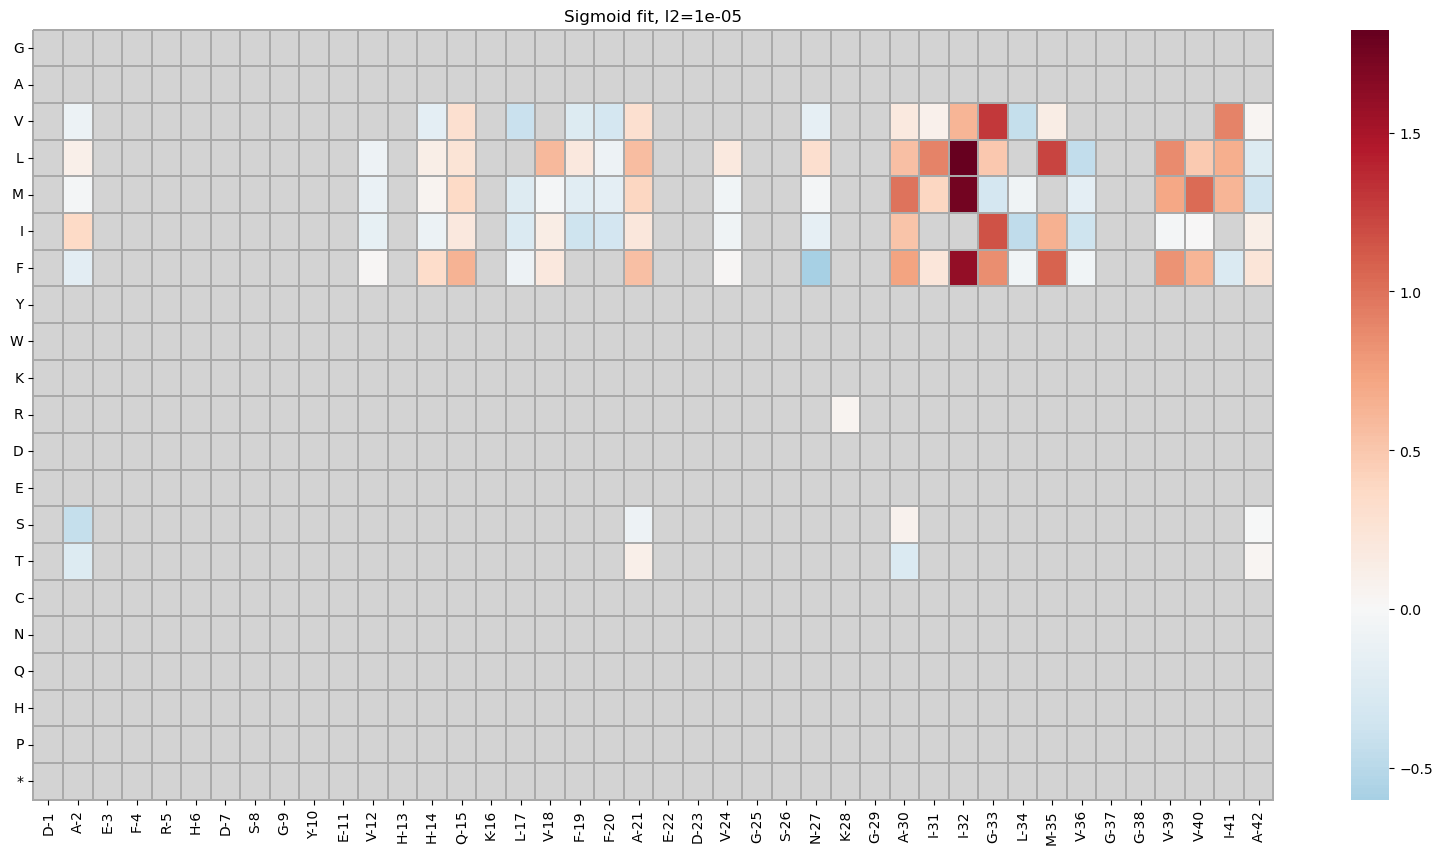

In [32]:
transformation = 'Sigmoid'
fig = plt.figure(figsize=(20, 10))
sns.heatmap(ddE_df_mean_kcalmol[transformation], cmap=cmaps_ddE[transformation], 
            #vmin = ddE_df_mean_kcalmol.fillna(0, inplace=False).to_numpy().min(),
            #vmax = 5,
            mask=masks_ddE[transformation],
            linewidths=0.002814, linecolor='darkgrey', clip_on=False,
            center=0)
plt.yticks(rotation=0) 
#plt.xticks(rotation=0) 
plt.title(transformation + ' fit, l2=1e-05')

#plt.savefig('./figures/20240206_mochi_ddEa_heatmap_all_3_doubles_1st_ord_terms_allowed_Sigmoid.pdf',
#           bbox_inches = 'tight')

Text(0.5, 1.0, 'Sigmoid fit, l2=1e-05')

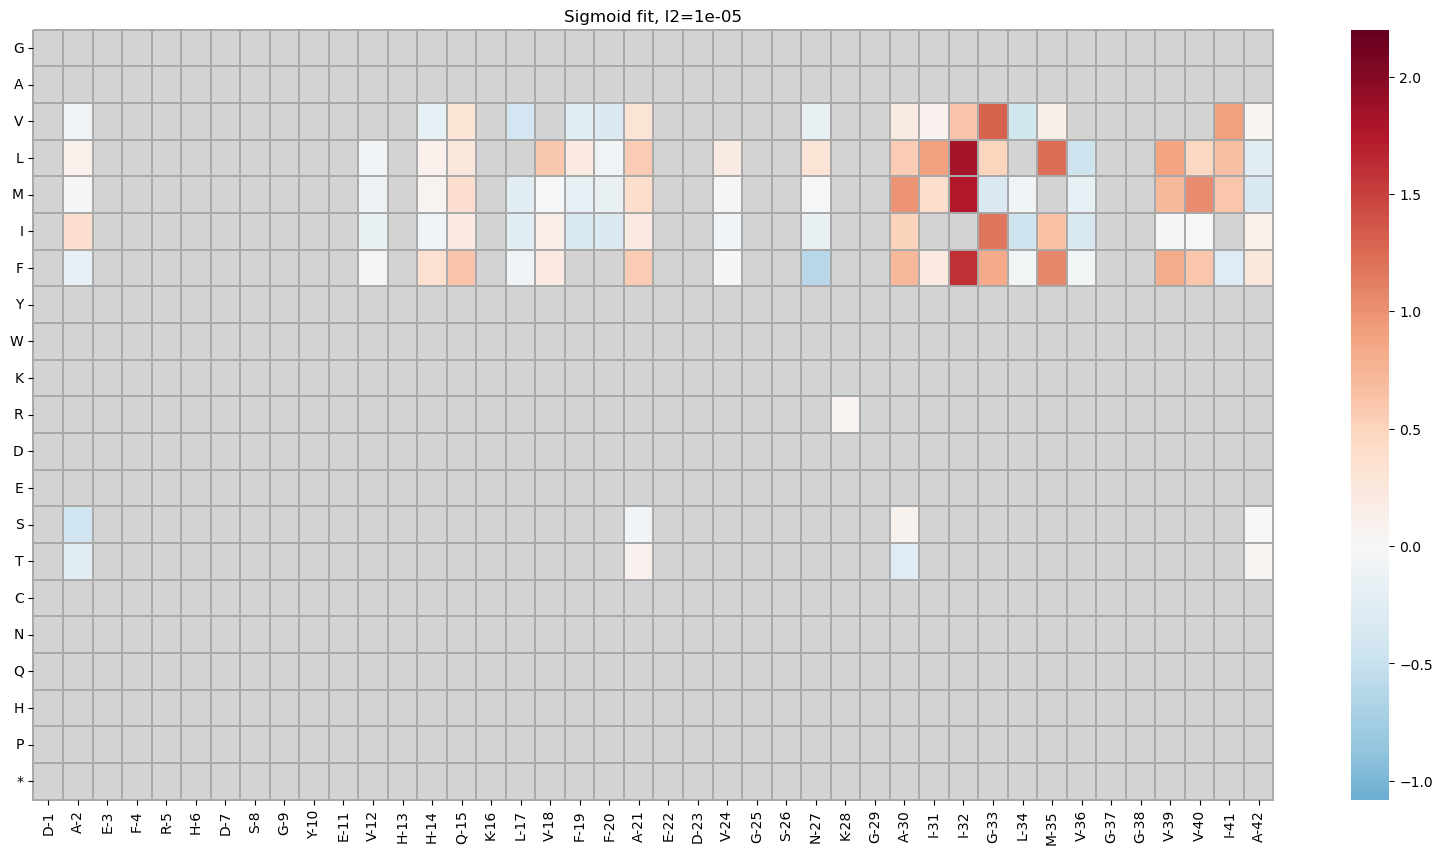

In [46]:
transformation = 'Sigmoid'
fig = plt.figure(figsize=(20, 10))
sns.heatmap(ddE_df_mean_kcalmol[transformation], cmap=cmaps_ddE[transformation], 
            vmin = ddE_df_mean_kcalmol_doubles[transformation].fillna(0, inplace=False).to_numpy().min(),
            vmax = ddE_df_mean_kcalmol_doubles[transformation].fillna(0, inplace=False).to_numpy().max(),
            mask=masks_ddE[transformation],
            linewidths=0.002814, linecolor='darkgrey', clip_on=False,
            center=0)
plt.yticks(rotation=0) 
#plt.xticks(rotation=0) 
plt.title(transformation + ' fit, l2=1e-05')

#plt.savefig('./figures/20240206_mochi_ddEa_heatmap_all_3_doubles_1st_ord_terms_allowed_Sigmoid.pdf',
#           bbox_inches = 'tight')

In [33]:
results_dir_doubles = '/lustre/scratch126/gengen/projects/amyloid_beta_epistasis/Doubles_analysis/all_vars_analysis/mochi_results/'

In [34]:
# here will look runs for all 3 doubles datasets
# Sigmoid, ELU and Linear fits

weights_Nucleation_doubles = {}

for transformation in transformations: 
    print(transformation)
        
    curr_path = results_dir_doubles + '20240219_max_terms_order_1_' + transformation + '_l2_regularization_factor_' + l2_regularisation_factor_value + '_all_3_doubles_datasets_all_variants'       


    weights_Nucleation_doubles[transformation] = pd.read_csv(curr_path + '/weights/weights_Nucleation.txt',
                                sep='\t')


Sigmoid
ELU
Linear


In [20]:
weights_Nucleation_doubles['ELU']

id id_ref   Pos  Pos_ref    fold_1    fold_2    fold_3    fold_4  \
0      WT     WT   NaN      NaN  1.095211  1.082703  1.020190  1.033223   
1     D1*    D1*   1.0      1.0 -1.891814 -2.114409 -1.773120 -2.369479   
2     D1A    D1A   1.0      1.0  0.036011  0.047905  0.052902  0.001233   
3     D1C    D1C   1.0      1.0  0.006093 -0.013409  0.042425  0.016337   
4     D1E    D1E   1.0      1.0 -0.043760 -0.056564 -0.047385 -0.053662   
..    ...    ...   ...      ...       ...       ...       ...       ...   
836  A42T   A42T  42.0     42.0  0.101390  0.108238  0.160273  0.148486   
837  A42V   A42V  42.0     42.0  0.189960  0.266326  0.232132  0.188135   
838  A42W   A42W  42.0     42.0 -1.580275 -1.531054 -1.262960 -0.910915   
839  A42Y   A42Y  42.0     42.0 -0.784715 -0.733691 -0.834396 -0.838072   
840  E11M   E11M  11.0     11.0       NaN -0.393013 -0.708041 -0.636612   

       fold_5    fold_6  ...    fold_9   fold_10   n      mean       std  \
0    1.072540  1.063402  ...  1.107965  1.065404  10  1.055407  0.037865   
1   -1.937678 -1.833339  ... -1.994781 -1.827042  10 -1.952647  0.209381   
2    0.028088  0.046580  ...  0.021083  0.075275  10  0.042267  0.021208   
3    0.054700  0.075768  ...  0.101583  0.033586  10  0.041323  0.033502   
4   -0.040730 -0.052668  ... -0.043659 -0.056167  10 -0.050365  0.007919   
..        ...       ...  ...       ...       ...  ..       ...       ...   
836  0.061055  0.050176  ...  0.160931  0.192142  10  0.121450  0.046179   
837  0.203503  0.215586  ...  0.206672  0.233836  10  0.217187  0.027760   
838 -1.434673 -0.813418  ... -1.103362 -0.939298  10 -1.241221  0.279881   
839 -0.998024 -0.724463  ... -0.852893 -0.846774  10 -0.812773  0.082256   
840 -0.544141 -0.710750  ... -0.780008 -1.061046   9 -0.704523  0.187305   

         ci95  trait_name  mean_kcal/mol std_kcal/mol  ci95_kcal/mol  
0    0.148430  Nucleation       0.635420     0.022797       0.089364  
1    0.820775  Nucleation      -1.175613     0.126060       0.494157  
2    0.083134  Nucleation       0.025447     0.012768       0.050052  
3    0.131326  Nucleation       0.024879     0.020170       0.079066  
4    0.031041  Nucleation      -0.030323     0.004767       0.018688  
..        ...         ...            ...          ...            ...  
836  0.181023  Nucleation       0.073120     0.027803       0.108987  
837  0.108818  Nucleation       0.130760     0.016713       0.065515  
838  1.097132  Nucleation      -0.747291     0.168505       0.660540  
839  0.322443  Nucleation      -0.489339     0.049523       0.194130  
840  0.734237  Nucleation      -0.424166     0.112769       0.442056  

[841 rows x 22 columns]

In [35]:
# table of all possible 20 aa in all possible Ab (42) positions

ddE_df_mean_kcalmol_doubles = {}

for l2_regularisation_factor_value in l2_regularisation_factor_values:
    for transformation in transformations:
        #print(transformation)
        ddE_df_mean_kcalmol_doubles[transformation] = pd.DataFrame(columns=[elem + '-' + str(idx+1) for idx,elem in enumerate(list(AB_WT))], 
                                                           index = list(all_aa))

In [36]:
# populate the ddE_df table according to weights_Nucleation

for l2_regularisation_factor_value in l2_regularisation_factor_values:
    
    for transformation in transformations:

        for idx in list(weights_Nucleation_doubles[transformation].index):

            curr_mutation_id = weights_Nucleation_doubles[transformation].loc[idx,'id']

            # continue if not WT
            if curr_mutation_id != 'WT':
                # position (1-42) of mutation in Ab sequence
                curr_mutation_pos = curr_mutation_id[1:-1]
                # aa introduced by the mutation
                curr_new_aa = curr_mutation_id[-1]

                # inferred value of ddEa to be added
                curr_ddEa_value = weights_Nucleation_doubles[transformation].loc[idx,'mean_kcal/mol']

                # minus because we have -ddEa predicted
                ddE_df_mean_kcalmol_doubles[transformation].loc[curr_new_aa, list(ddE_df_mean_kcalmol_doubles[transformation].columns)[int(curr_mutation_pos) - 1]] = -curr_ddEa_value


In [37]:
# make sure values are float
for l2_regularisation_factor_value in l2_regularisation_factor_values:
    for transformation in transformations:
        for col in list(ddE_df_mean_kcalmol_doubles[transformation].columns):
            ddE_df_mean_kcalmol_doubles[transformation][col] = ddE_df_mean_kcalmol_doubles[transformation][col].astype(float)


In [38]:
# overlap in variants b/w DTS and doubles
common_vars_sigmoid = list(set(weights_Nucleation_doubles['Sigmoid']['id']) & set(weights_Nucleation['Sigmoid']['id']))
len(common_vars_sigmoid)

106

In [39]:
y = list(weights_Nucleation_doubles['Sigmoid'].set_index('id', inplace=False).loc[common_vars_sigmoid,'mean_kcal/mol'])
x = list(weights_Nucleation['Sigmoid'].set_index('id', inplace=False).loc[common_vars_sigmoid,'mean_kcal/mol'])


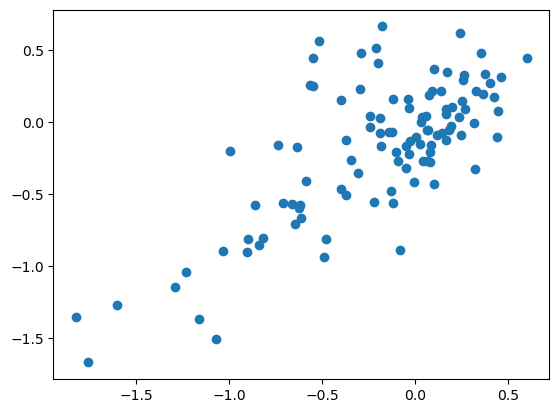

In [40]:
plt.scatter(x, y)

In [41]:
import scipy


In [42]:
scipy.stats.pearsonr(x,y)

(0.7384215297696424, 1.6752906360880753e-19)

Text(0.5, 1.0, 'corr=0.7384215297696425')

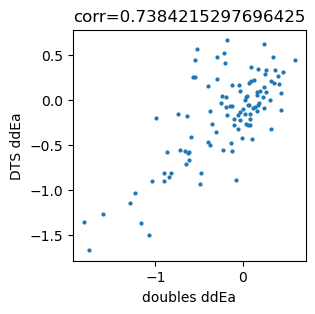

In [43]:
labels = common_vars_sigmoid

fig, ax = plt.subplots(figsize=(3,3))
ax.scatter(x, y, s=4)

#plt.axline((0, 0), (1, 1), linewidth=1, color='r')

plt.xlabel('doubles ddEa')
plt.ylabel('DTS ddEa')
plt.title('corr=' + str(np.corrcoef(x, y)[0][1]))


#for i, txt in enumerate(mutations):
#    ax.annotate(txt, (x[i], y[i]), fontsize=10)

In [48]:
# plotting second order terms
weights_Nucleation['Sigmoid']

id     id_ref    Pos Pos_ref    fold_1    fold_2    fold_3  \
0            WT         WT    NaN     NaN  0.261837  0.204665  0.165172   
1           A2F        A2F      2       2  0.372272  0.491585  0.442740   
2           A2I        A2I      2       2 -1.010018 -0.452616 -0.598237   
3           A2L        A2L      2       2  0.420973 -0.343920 -0.405201   
4           A2M        A2M      2       2 -0.006749  0.110465  0.062144   
...         ...        ...    ...     ...       ...       ...       ...   
4612  A21L_V39L  A21L_V39L  21_39   21_39  0.175288  0.206282 -0.043510   
4613   A2M_I41V   A2M_I41V   2_41    2_41 -0.444197 -0.444630 -0.247490   
4614  H14M_V39F  H14M_V39F  14_39   14_39 -0.406366 -0.615578  0.117950   
4615  M35I_A42I  M35I_A42I  35_42   35_42  0.098628 -0.230654 -0.397257   
4616  Q15I_A21L  Q15I_A21L  15_21   15_21       NaN -0.026568 -0.050205   

        fold_4    fold_5    fold_6  ...    fold_9   fold_10   n      mean  \
0     0.255869  0.372799  0.238893  ...  0.278167  0.165111  10  0.224718   
1     0.142492  0.319884  0.166345  ... -0.291864  0.192754  10  0.313232   
2    -1.070924 -0.459095 -0.441248  ... -0.861913 -0.536645  10 -0.616712   
3     0.549784  0.136807 -0.664731  ... -0.644024 -0.517604  10 -0.196826   
4     0.386431 -0.039186  0.453593  ... -0.035029  0.066639  10  0.065100   
...        ...       ...       ...  ...       ...       ...  ..       ...   
4612  0.136367 -0.005910  0.511449  ... -0.043015  0.162233  10  0.152538   
4613 -0.347330 -0.304744 -0.292701  ...  0.083417 -0.448979  10 -0.303001   
4614  0.001056 -0.297773 -0.060037  ...  0.321353  0.091670  10 -0.005498   
4615 -0.193451 -0.326780 -0.044635  ...  0.071852 -0.215639  10 -0.129680   
4616  0.040648  0.021356 -0.154608  ... -0.093778 -0.134120   9 -0.074143   

           std      ci95  trait_name  mean_kcal/mol std_kcal/mol  \
0     0.075817  0.297205  Nucleation       0.135294     0.045647   
1     0.283051  1.109562  Nucleation       0.188585     0.170414   
2     0.275127  1.078497  Nucleation      -0.371298     0.165643   
3     0.431402  1.691095  Nucleation      -0.118501     0.259730   
4     0.222650  0.872788  Nucleation       0.039194     0.134049   
...        ...       ...         ...            ...          ...   
4612  0.178858  0.701124  Nucleation       0.091837     0.107683   
4613  0.160358  0.628603  Nucleation      -0.182425     0.096545   
4614  0.348556  1.366338  Nucleation      -0.003310     0.209852   
4615  0.170750  0.669340  Nucleation      -0.078075     0.102802   
4616  0.075812  0.297184  Nucleation      -0.044639     0.045644   

      ci95_kcal/mol  
0          0.178935  
1          0.668024  
2          0.649321  
3          1.018142  
4          0.525472  
...             ...  
4612       0.422119  
4613       0.378457  
4614       0.822619  
4615       0.402983  
4616       0.178923  

[4617 rows x 22 columns]

Text(0.5, 1.0, 'ELU fit, l2=1e-05')

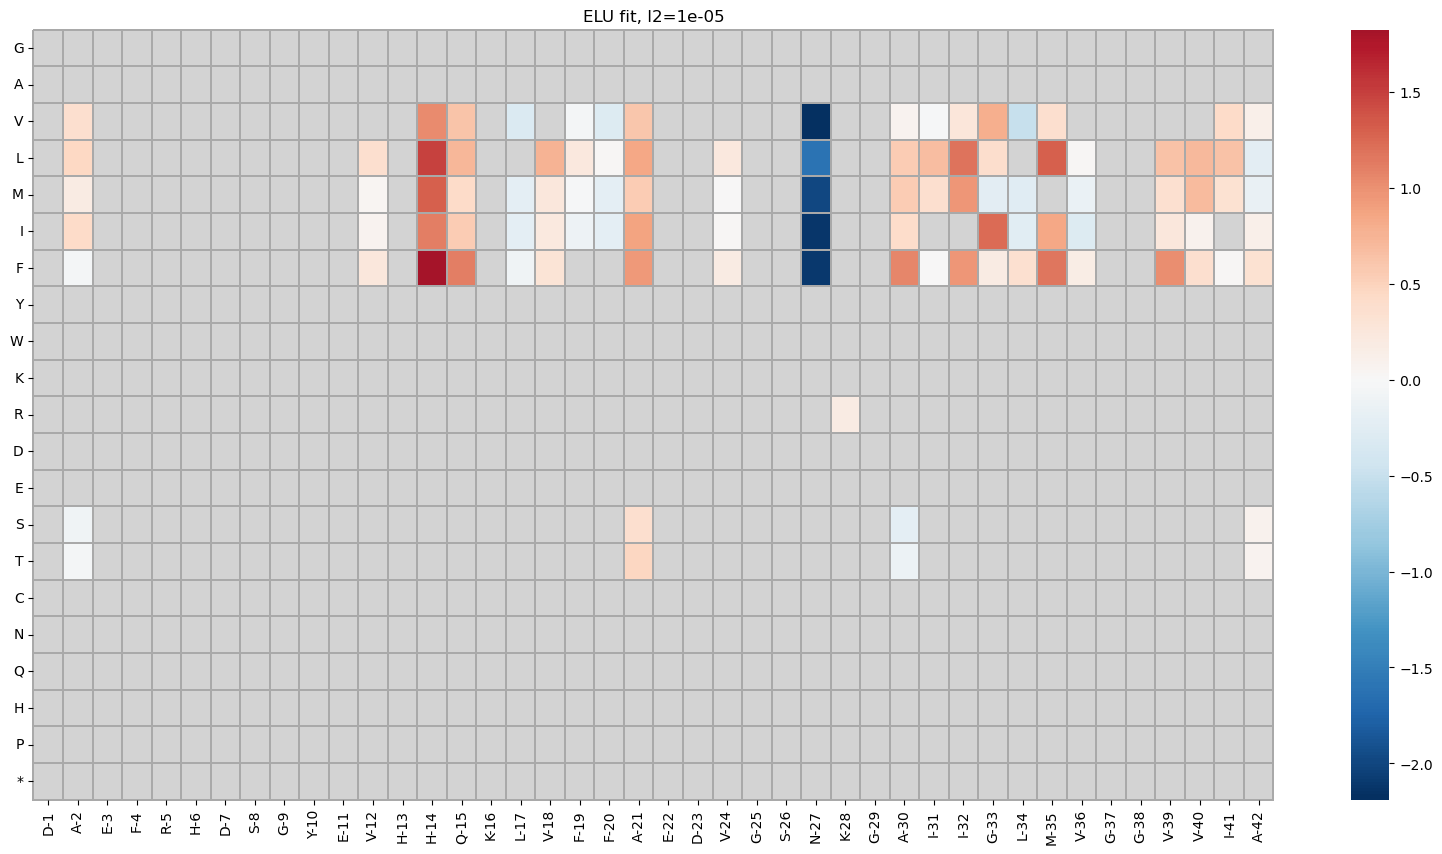

In [16]:
transformation = 'ELU'
fig = plt.figure(figsize=(20, 10))
sns.heatmap(ddE_df_mean_kcalmol[transformation], cmap=cmaps_ddE[transformation], 
            #vmin = ddE_df_mean_kcalmol.fillna(0, inplace=False).to_numpy().min(),
            #vmax = 5,
            mask=masks_ddE[transformation],
            linewidths=0.002814, linecolor='darkgrey', clip_on=False,
            center=0)
plt.yticks(rotation=0) 
#plt.xticks(rotation=0) 
plt.title(transformation + ' fit, l2=1e-05')

#plt.savefig('./figures/20240206_mochi_ddEa_heatmap_all_3_doubles_1st_ord_terms_allowed_Sigmoid.pdf',
#           bbox_inches = 'tight')

Text(0.5, 1.0, 'Linear fit, l2=1e-05')

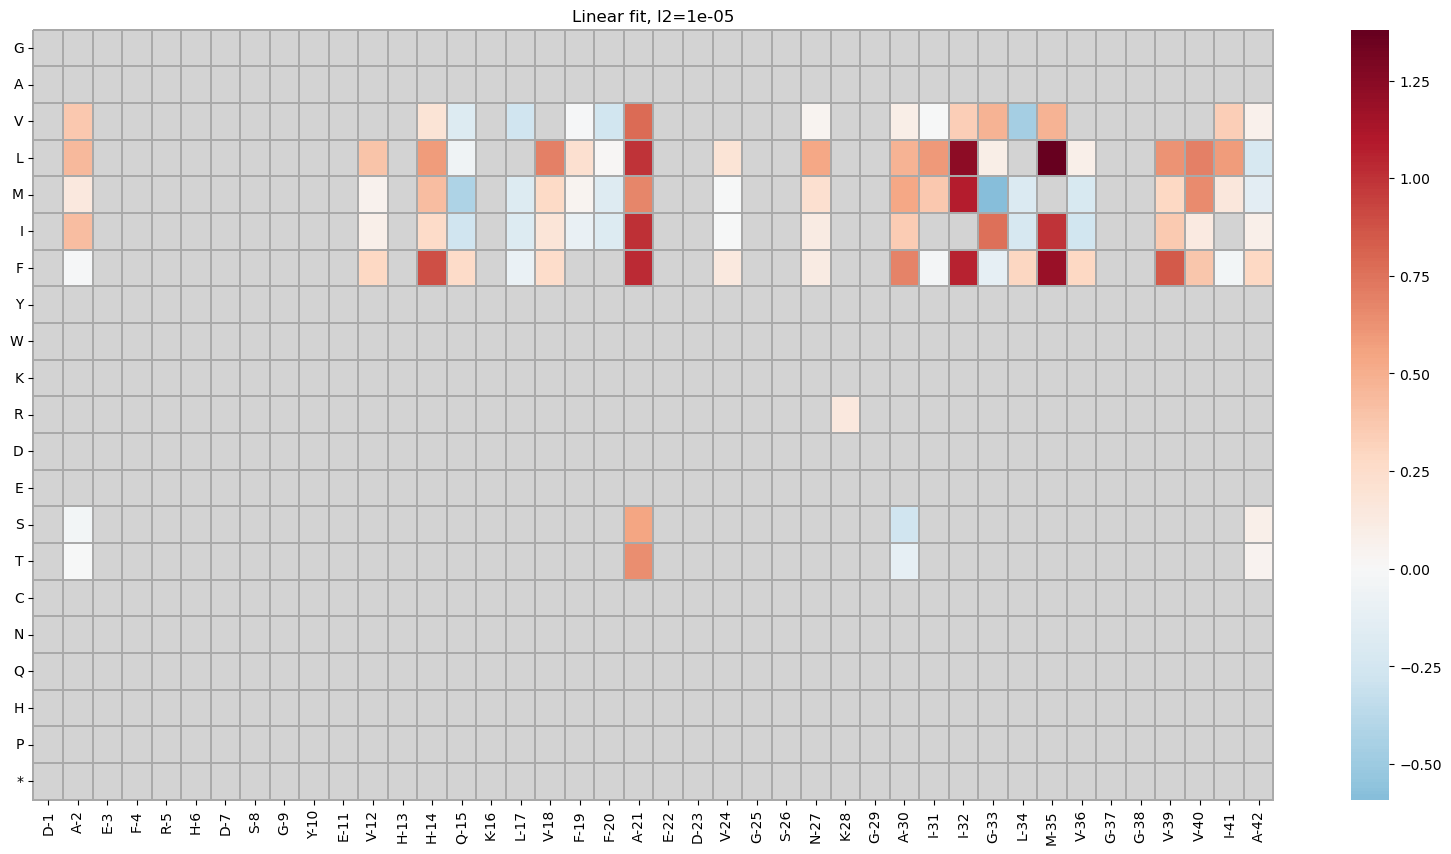

In [17]:
transformation = 'Linear'
fig = plt.figure(figsize=(20, 10))
sns.heatmap(ddE_df_mean_kcalmol[transformation], cmap=cmaps_ddE[transformation], 
            #vmin = ddE_df_mean_kcalmol.fillna(0, inplace=False).to_numpy().min(),
            #vmax = 5,
            mask=masks_ddE[transformation],
            linewidths=0.002814, linecolor='darkgrey', clip_on=False,
            center=0)
plt.yticks(rotation=0) 
#plt.xticks(rotation=0) 
plt.title(transformation + ' fit, l2=1e-05')

#plt.savefig('./figures/20240206_mochi_ddEa_heatmap_all_3_doubles_1st_ord_terms_allowed_Sigmoid.pdf',
#           bbox_inches = 'tight')

Text(0.5, 1.0, 'Sigmoid fit, l2=1e-05')

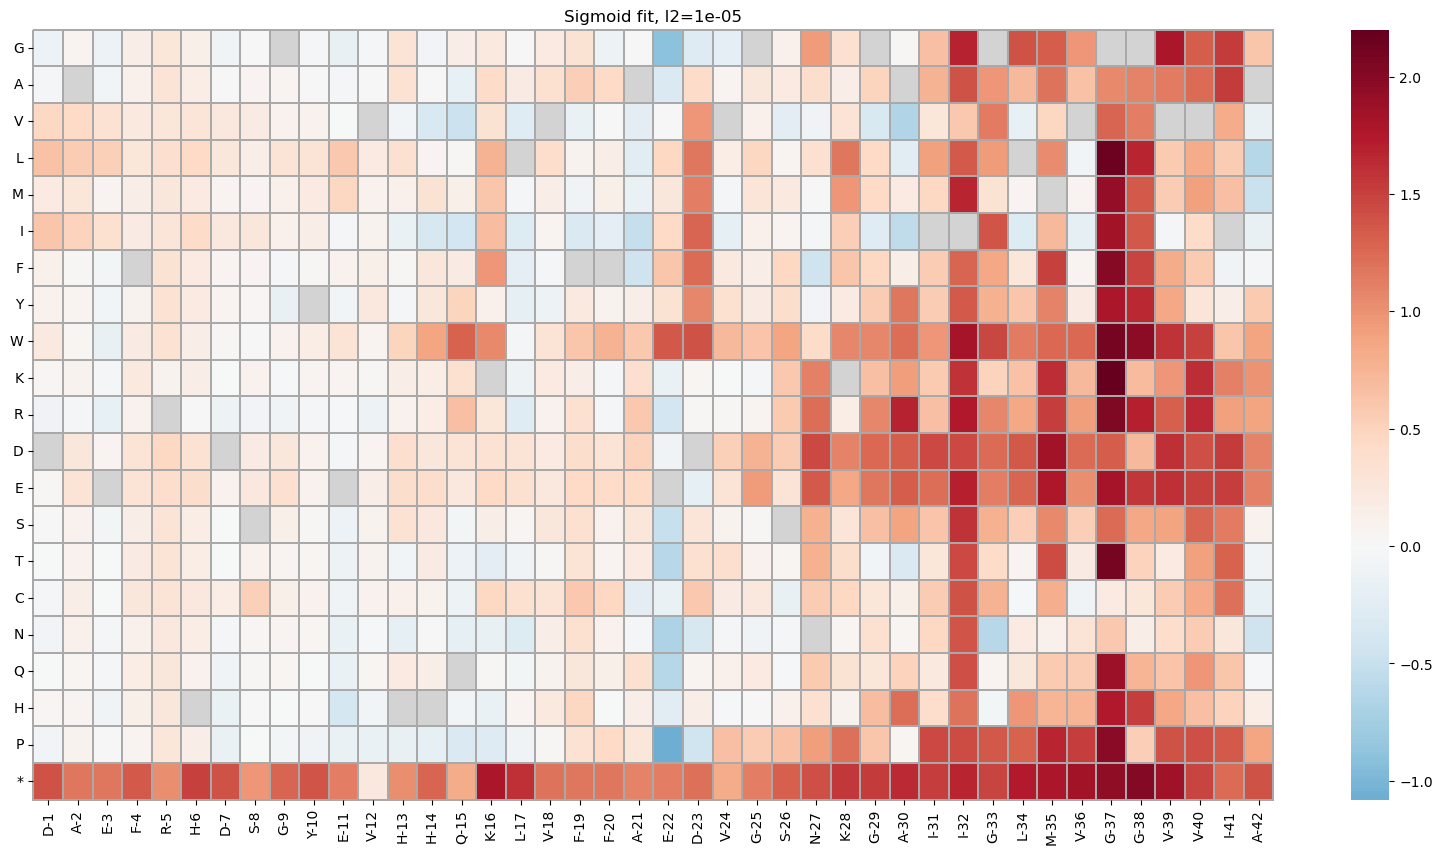

In [17]:
transformation = 'Sigmoid'
fig = plt.figure(figsize=(20, 10))
sns.heatmap(ddE_df_mean_kcalmol[transformation], cmap=cmaps_ddE[transformation], 
            #vmin = ddE_df_mean_kcalmol.fillna(0, inplace=False).to_numpy().min(),
            #vmax = 5,
            mask=masks_ddE[transformation],
            linewidths=0.002814, linecolor='darkgrey', clip_on=False,
            center=0)
plt.yticks(rotation=0) 
#plt.xticks(rotation=0) 
plt.title(transformation + ' fit, l2=1e-05')

#plt.savefig('./figures/20240206_mochi_ddEa_heatmap_all_3_doubles_1st_ord_terms_allowed_Sigmoid.pdf',
#           bbox_inches = 'tight')

Text(0.5, 1.0, 'ELU fit, l2=1e-05')

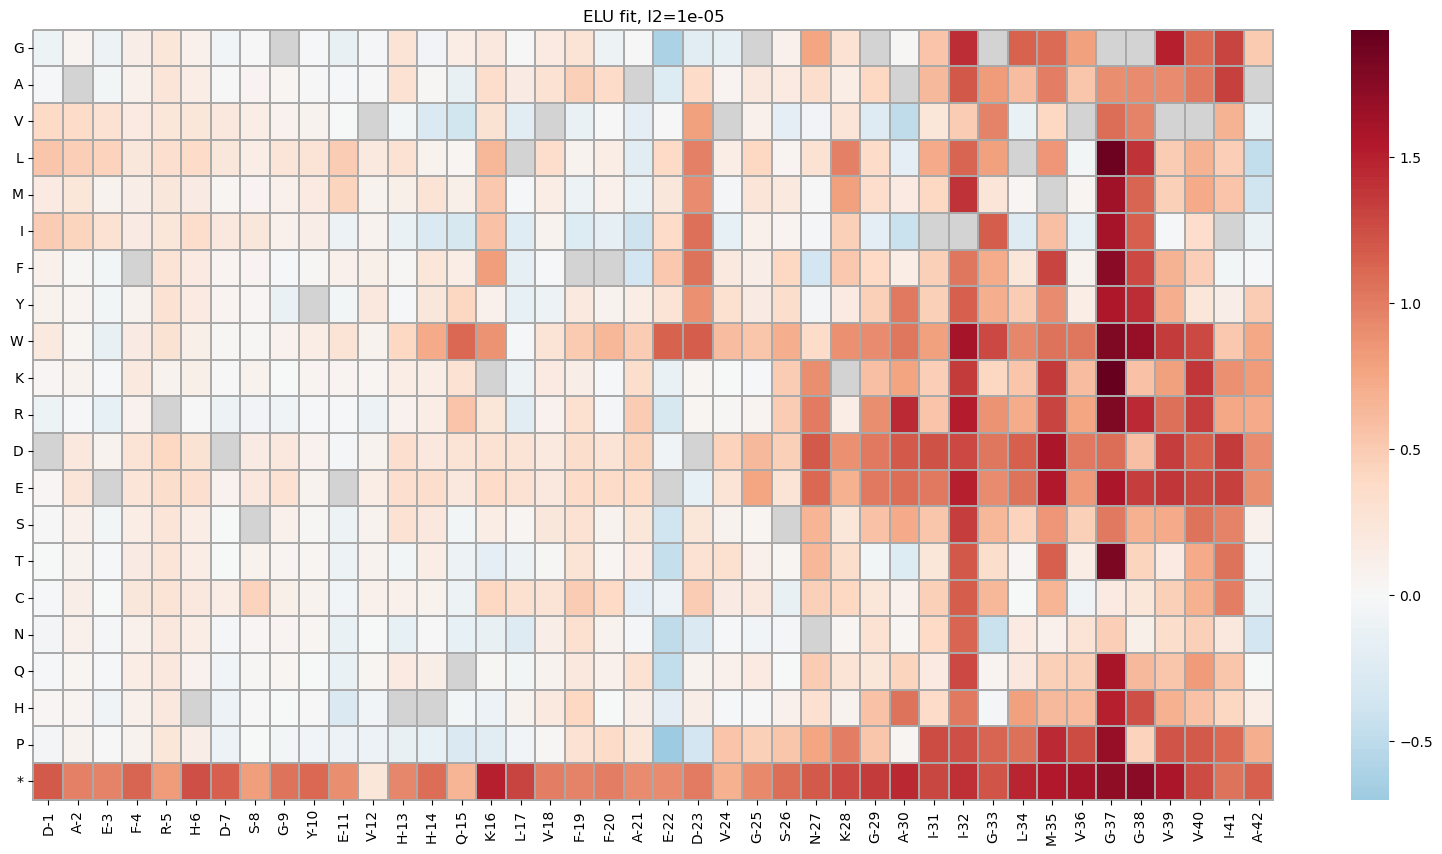

In [18]:
transformation = 'ELU'
fig = plt.figure(figsize=(20, 10))
sns.heatmap(ddE_df_mean_kcalmol[transformation], cmap=cmaps_ddE[transformation], 
            #vmin = ddE_df_mean_kcalmol.fillna(0, inplace=False).to_numpy().min(),
            #vmax = 5,
            mask=masks_ddE[transformation],
            linewidths=0.002814, linecolor='darkgrey', clip_on=False,
            center=0)
plt.yticks(rotation=0) 
#plt.xticks(rotation=0) 
plt.title(transformation + ' fit, l2=1e-05')

#plt.savefig('./figures/20240206_mochi_ddEa_heatmap_all_3_doubles_1st_ord_terms_allowed_Sigmoid.pdf',
#           bbox_inches = 'tight')

In [19]:
ELU_values = [x for xs in ddE_df_mean_kcalmol['ELU'].values for x in xs]
ELU_values = [elem for elem in ELU_values if str(elem)!='nan']
Sigmoid_values = [x for xs in ddE_df_mean_kcalmol['Sigmoid'].values for x in xs]
Sigmoid_values = [elem for elem in Sigmoid_values if str(elem)!='nan']


In [20]:
np.corrcoef(ELU_values,Sigmoid_values)[0][1]

0.9992748633674262

In [21]:
#predictions

In [37]:
# looking at mochi results from Mireia's separate runs on 3 doubles datasets

weights_Mireia = {}

weights_Mireia['eLife_doubles'] = pd.read_csv('/lustre/scratch126/gengen/projects/amyloid_beta_epistasis/Previous_files_from_Mireia/Doubles_datasets/_nov22_NEW_analysis_doubles/_nov22_elife_doubles_analysis/mochi/mochi_elife_classifiable_regression_TwoStateFractionFolded/weights/weights_Nucleation.txt',
                                             sep='\t')
# not sure if this is the right NNK model (there are many more), just following the naming of the other ones
weights_Mireia['NNK_doubles'] = pd.read_csv('/lustre/scratch126/gengen/projects/amyloid_beta_epistasis/Previous_files_from_Mireia/Doubles_datasets/_nov22_NEW_analysis_doubles/_nov22_NNK_analysis/mochi/mochi_NNKfu_classifiable_regression_TwoStateFractionFolded/weights/weights_Nucleation.txt',
                                             sep='\t')
weights_Mireia['Nicking_doubles'] = pd.read_csv('/lustre/scratch126/gengen/projects/amyloid_beta_epistasis/Previous_files_from_Mireia/Doubles_datasets/_nov22_NEW_analysis_doubles/_nov22_nicking_NT/mochi/mochi_nicking_classifiable_regression_TwoStateFractionFolded/weights/weights_Nucleation.txt',
                                             sep='\t')



In [38]:
weights_Mireia['eLife_doubles']

id id_ref   Pos  Pos_ref    fold_1    fold_2    fold_3    fold_4  \
0      WT     WT   NaN      NaN -0.842668 -0.776608 -0.834421 -0.852575   
1     D1*    D1*   1.0      1.0  1.197059  1.291969       NaN       NaN   
2     D1A    D1A   1.0      1.0 -0.044337  0.105792  0.725615 -0.016255   
3     D1C    D1C   1.0      1.0  0.488139 -0.122273 -0.161848       NaN   
4     D1E    D1E   1.0      1.0  0.059049  0.052599  0.104236  0.080160   
5     D1G    D1G   1.0      1.0 -0.355255 -0.333482 -0.327137 -0.222435   
6     D1H    D1H   1.0      1.0  0.877780  0.023700  0.014529  0.177377   
7     D1I    D1I   1.0      1.0  1.410172  1.527470  1.517622  1.346077   
8     D1K    D1K   1.0      1.0 -0.195043 -0.175920 -0.197482 -0.201832   
9     D1N    D1N   1.0      1.0 -0.145116 -0.077756 -0.144178 -0.121459   
10    D1S    D1S   1.0      1.0 -0.254678       NaN       NaN       NaN   
11    D1T    D1T   1.0      1.0  4.978903  1.752936  4.985008  1.097174   
12    D1V    D1V   1.0      1.0  0.972306  0.971887  0.975536  0.913858   
13    D1Y    D1Y   1.0      1.0  0.391899  0.362795  0.180822  0.161282   
14    A2D    A2D   2.0      2.0  0.387867  0.157302       NaN       NaN   
15    A2E    A2E   2.0      2.0  0.598377  0.616079  0.601888  0.601413   
16    A2G    A2G   2.0      2.0  0.632237  0.497655  0.226557  0.204029   
17    A2I    A2I   2.0      2.0  2.376476  2.709676  1.757363  1.623672   
18    A2K    A2K   2.0      2.0 -0.125621  0.170224  0.520901 -0.357904   
19    A2P    A2P   2.0      2.0  0.229313  0.316937  0.300621  0.197770   
20    A2S    A2S   2.0      2.0  0.288903  0.248130  0.269229  0.253996   
21    A2T    A2T   2.0      2.0  0.284693  0.240090  0.269375  0.257687   
22    A2V    A2V   2.0      2.0  0.972636  0.887279  0.955080  0.947487   
23    E3*    E3*   3.0      3.0  1.985175  1.889689  2.039471  1.871364   
24    E3A    E3A   3.0      3.0 -0.016694  0.131120  0.113319  0.079539   
25    E3D    E3D   3.0      3.0  0.530609  0.485341  0.577044  0.300082   
26    E3G    E3G   3.0      3.0 -0.233560 -0.218577 -0.241024 -0.332918   
27    E3K    E3K   3.0      3.0 -0.064463 -0.056348 -0.128969 -0.153894   
28    E3L    E3L   3.0      3.0  1.671874  2.005149  1.470285  2.214320   
29    E3Q    E3Q   3.0      3.0  0.040379 -0.038333 -0.030012  0.825260   
30    E3R    E3R   3.0      3.0 -4.014385  0.144160  1.126995  0.533200   
31    E3T    E3T   3.0      3.0  1.038367  1.225312  5.153574       NaN   
32    E3V    E3V   3.0      3.0  0.873407  0.802722  0.798224  0.747569   
33    E3W    E3W   3.0      3.0  0.447764       NaN       NaN       NaN   
34    F4C    F4C   4.0      4.0  0.622445  0.449493  0.398229  0.445603   
35    F4H    F4H   4.0      4.0  0.957622  0.971946  0.640339  0.625228   
36    F4I    F4I   4.0      4.0  0.377362  0.408852  0.406993  0.439655   
37    F4L    F4L   4.0      4.0  0.633280  0.631517  0.656990  0.654019   
38    F4P    F4P   4.0      4.0  0.590140  0.570968       NaN       NaN   
39    F4S    F4S   4.0      4.0  0.288409  0.311152  0.338076  0.376703   
40    F4V    F4V   4.0      4.0  0.280756  0.401141  0.338621  0.437410   
41    F4Y    F4Y   4.0      4.0  0.173842  0.132995  0.158296  0.217187   
42    R5*    R5*   5.0      5.0  2.256075  2.247581  2.198625  2.118732   
43    R5C    R5C   5.0      5.0  1.427692  1.327201  0.814356  0.818892   
44    R5G    R5G   5.0      5.0  0.887415  0.796602  0.616589  0.497283   
45    R5H    R5H   5.0      5.0  0.513833  0.210319       NaN       NaN   
46    R5I    R5I   5.0      5.0  0.876027  1.060497  0.568222  0.408180   
47    R5K    R5K   5.0      5.0  0.259810       NaN       NaN       NaN   
48    R5L    R5L   5.0      5.0  0.740652  0.726542  0.689855  0.761357   
49    R5P    R5P   5.0      5.0  1.092988  0.520357  0.539685  0.591012   
50    R5Q    R5Q   5.0      5.0  0.535092  0.479527  0.622934  0.577285   
51    R5S    R5S   5.0      5.0  1.043536  0.997792  1.503556  0.899001   
52    H6*    H6*   6.0      6.0 

In [39]:
# looking at how well the values for the same vars correlate in
# my Sigmoid fit (joint model) and Mireia's eLife_doubles model
# my Sigmoid fit (joint model) and Mireia's NNK_doubles model
# my Sigmoid fit (joint model) and Mireia's Nicking_doubles model
# and 
# my ELU fit (joint model) and Mireia's eLife_doubles model
# my ELU fit (joint model) and Mireia's NNK_doubles model
# my ELU fit (joint model) and Mireia's Nicking_doubles model

In [40]:
len(weights_Mireia['eLife_doubles'])

468

In [41]:
# checking common variants
len(set(weights_Mireia['eLife_doubles']['id']) & set(weights_Nucleation['Sigmoid_l2_1e-05']['id']))

468

In [42]:
#weights_Mireia['eLife_doubles']

In [43]:
len(weights_Mireia['NNK_doubles'])

301

In [44]:
# checking common variants
# here be careful - since it was the C-terminus mutated, need to translate the positions
len(set(weights_Mireia['NNK_doubles']['id']) & set(weights_Nucleation['Sigmoid_l2_1e-05']['id']))

20

In [45]:
#weights_Mireia['NNK_doubles']

In [46]:
# going to correct the position in mutation id complementing the Ab sequence
weights_Mireia['NNK_doubles']['id_complemented'] = [0]*len(weights_Mireia['NNK_doubles'])

In [47]:
for idx in list(weights_Mireia['NNK_doubles'].index):
    
    curr_mutation_id = weights_Mireia['NNK_doubles'].loc[idx,'id']
    #print(curr_mutation_id)
    
    if curr_mutation_id != 'WT':
        curr_mutation_position = curr_mutation_id[1:-1]
        complemented_mutation_position = int(curr_mutation_position) + 27
        complemented_mutation_id = curr_mutation_id[0] + str(complemented_mutation_position) + curr_mutation_id[-1]
        weights_Mireia['NNK_doubles'].loc[idx,'id_complemented'] = complemented_mutation_id
    else:
        # if WT, leave as it was
        weights_Mireia['NNK_doubles'].loc[idx,'id_complemented'] = curr_mutation_id
    

In [48]:
len(weights_Mireia['NNK_doubles'])

301

In [49]:
# checking common variants
len(set(weights_Mireia['NNK_doubles']['id_complemented']) & set(weights_Nucleation['Sigmoid_l2_1e-05']['id']))

301

In [50]:
len(weights_Mireia['Nicking_doubles'])

558

In [51]:
# checking common variants
len(set(weights_Mireia['Nicking_doubles']['id']) & set(weights_Nucleation['Sigmoid_l2_1e-05']['id']))

558

In [52]:
comon_vars = {}

comon_vars['joint_Sigmoid_and_eLife_Mireia'] = list(set(weights_Mireia['eLife_doubles']['id']) & set(weights_Nucleation['Sigmoid_l2_1e-05']['id']))
comon_vars['joint_Sigmoid_and_NNK_Mireia'] = list(set(weights_Mireia['NNK_doubles']['id_complemented']) & set(weights_Nucleation['Sigmoid_l2_1e-05']['id']))
comon_vars['joint_Sigmoid_and_Nicking_Mireia'] = list(set(weights_Mireia['Nicking_doubles']['id']) & set(weights_Nucleation['Sigmoid_l2_1e-05']['id']))

comon_vars['joint_ELU_and_eLife_Mireia'] = list(set(weights_Mireia['eLife_doubles']['id']) & set(weights_Nucleation['ELU_l2_1e-05']['id']))
comon_vars['joint_ELU_and_NNK_Mireia'] = list(set(weights_Mireia['NNK_doubles']['id_complemented']) & set(weights_Nucleation['ELU_l2_1e-05']['id']))
comon_vars['joint_ELU_and_Nicking_Mireia'] = list(set(weights_Mireia['Nicking_doubles']['id']) & set(weights_Nucleation['ELU_l2_1e-05']['id']))



In [53]:
scatter_dfs = {}

#keys_scatter_dfs = ['joint_Sigmoid_and_eLife_Mireia', ]

scatter_dfs['joint_Sigmoid_and_eLife_Mireia'] = pd.DataFrame(index = comon_vars['joint_Sigmoid_and_eLife_Mireia'],
                                                             columns = ['ddEa_joint_Sigmoid','ddEa_eLife_Mireia'])
scatter_dfs['joint_Sigmoid_and_NNK_Mireia'] = pd.DataFrame(index = comon_vars['joint_Sigmoid_and_NNK_Mireia'],
                                                             columns = ['ddEa_joint_Sigmoid','ddEa_NNK_Mireia'])
scatter_dfs['joint_Sigmoid_and_Nicking_Mireia'] = pd.DataFrame(index = comon_vars['joint_Sigmoid_and_Nicking_Mireia'],
                                                             columns = ['ddEa_joint_Sigmoid','ddEa_NickingMireia'])



scatter_dfs['joint_ELU_and_eLife_Mireia'] = pd.DataFrame(index = comon_vars['joint_ELU_and_eLife_Mireia'],
                                                             columns = ['ddEa_joint_ELU','ddEa_eLife_Mireia'])
scatter_dfs['joint_ELU_and_NNK_Mireia'] = pd.DataFrame(index = comon_vars['joint_ELU_and_NNK_Mireia'],
                                                             columns = ['ddEa_joint_ELU','ddEa_NNK_Mireia'])
scatter_dfs['joint_ELU_and_Nicking_Mireia'] = pd.DataFrame(index = comon_vars['joint_ELU_and_Nicking_Mireia'],
                                                             columns = ['ddEa_joint_ELU','ddEa_Nicking_Mireia'])


In [54]:
scatter_dfs['joint_Sigmoid_and_eLife_Mireia'].head()

ddEa_joint_Sigmoid ddEa_eLife_Mireia
S8L                 NaN               NaN
H6P                 NaN               NaN
G29Y                NaN               NaN
D23N                NaN               NaN
M35I                NaN               NaN

In [55]:
scatter_dfs['joint_Sigmoid_and_eLife_Mireia']['ddEa_joint_Sigmoid'] = weights_Nucleation['Sigmoid_l2_1e-05'].set_index('id', inplace=False).loc[comon_vars['joint_Sigmoid_and_eLife_Mireia'],'mean_kcal/mol']
scatter_dfs['joint_Sigmoid_and_eLife_Mireia']['ddEa_eLife_Mireia'] = -weights_Mireia['eLife_doubles'].set_index('id', inplace=False).loc[comon_vars['joint_Sigmoid_and_eLife_Mireia'],'mean_kcal/mol']

scatter_dfs['joint_Sigmoid_and_NNK_Mireia']['ddEa_joint_Sigmoid'] = weights_Nucleation['Sigmoid_l2_1e-05'].set_index('id', inplace=False).loc[comon_vars['joint_Sigmoid_and_NNK_Mireia'],'mean_kcal/mol']
scatter_dfs['joint_Sigmoid_and_NNK_Mireia']['ddEa_NNK_Mireia'] = -weights_Mireia['NNK_doubles'].set_index('id_complemented', inplace=False).loc[comon_vars['joint_Sigmoid_and_NNK_Mireia'],'mean_kcal/mol']

scatter_dfs['joint_Sigmoid_and_Nicking_Mireia']['ddEa_joint_Sigmoid'] = weights_Nucleation['Sigmoid_l2_1e-05'].set_index('id', inplace=False).loc[comon_vars['joint_Sigmoid_and_Nicking_Mireia'],'mean_kcal/mol']
scatter_dfs['joint_Sigmoid_and_Nicking_Mireia']['ddEa_Nicking_Mireia'] = -weights_Mireia['Nicking_doubles'].set_index('id', inplace=False).loc[comon_vars['joint_Sigmoid_and_Nicking_Mireia'],'mean_kcal/mol']



scatter_dfs['joint_ELU_and_eLife_Mireia']['ddEa_joint_ELU'] = weights_Nucleation['ELU_l2_1e-05'].set_index('id', inplace=False).loc[comon_vars['joint_ELU_and_eLife_Mireia'],'mean_kcal/mol']
scatter_dfs['joint_ELU_and_eLife_Mireia']['ddEa_eLife_Mireia'] = -weights_Mireia['eLife_doubles'].set_index('id', inplace=False).loc[comon_vars['joint_ELU_and_eLife_Mireia'],'mean_kcal/mol']

scatter_dfs['joint_ELU_and_NNK_Mireia']['ddEa_joint_ELU'] = weights_Nucleation['ELU_l2_1e-05'].set_index('id', inplace=False).loc[comon_vars['joint_ELU_and_NNK_Mireia'],'mean_kcal/mol']
scatter_dfs['joint_ELU_and_NNK_Mireia']['ddEa_NNK_Mireia'] = -weights_Mireia['NNK_doubles'].set_index('id_complemented', inplace=False).loc[comon_vars['joint_ELU_and_NNK_Mireia'],'mean_kcal/mol']

scatter_dfs['joint_ELU_and_Nicking_Mireia']['ddEa_joint_ELU'] = weights_Nucleation['ELU_l2_1e-05'].set_index('id', inplace=False).loc[comon_vars['joint_ELU_and_Nicking_Mireia'],'mean_kcal/mol']
scatter_dfs['joint_ELU_and_Nicking_Mireia']['ddEa_Nicking_Mireia'] = -weights_Mireia['Nicking_doubles'].set_index('id', inplace=False).loc[comon_vars['joint_ELU_and_Nicking_Mireia'],'mean_kcal/mol']




In [56]:
#scatter_dfs['joint_Sigmoid_and_eLife_Mireia']

In [57]:
scatter_dfs['joint_Sigmoid_and_eLife_Mireia'].columns

Index(['ddEa_joint_Sigmoid', 'ddEa_eLife_Mireia'], dtype='object')

In [58]:
np.corrcoef(scatter_dfs['joint_Sigmoid_and_eLife_Mireia']['ddEa_eLife_Mireia'], scatter_dfs['joint_Sigmoid_and_eLife_Mireia']['ddEa_joint_Sigmoid'])[0][1]


0.8674195725095378

Text(0, 0.5, 'ddEa_Nicking_Mireia')

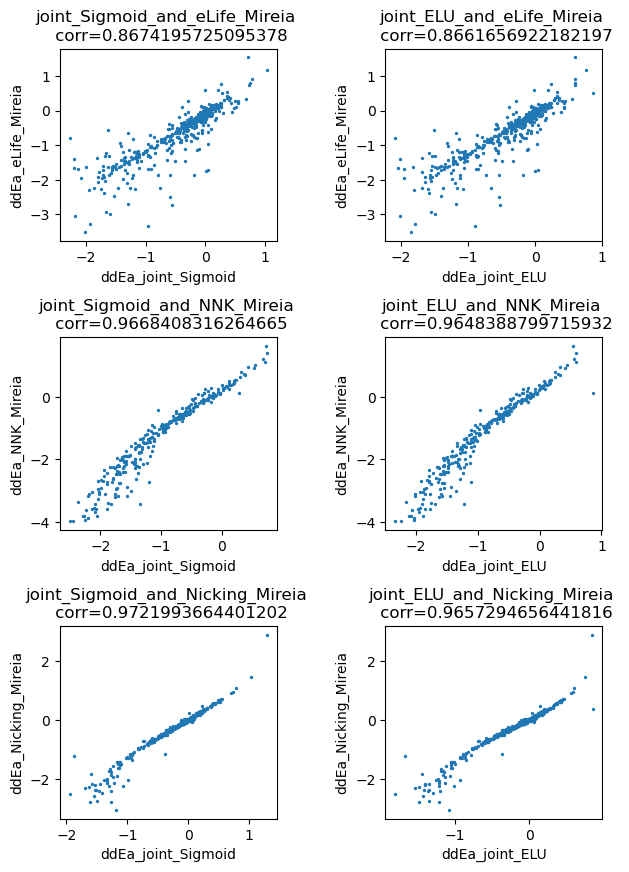

In [59]:
# plotting for run with all 3 doubles datasets

fig, axs = plt.subplots(3, 2, 
                        figsize=(7, 10))
fig.subplots_adjust(hspace=0.5, wspace = 0.5)
#fig.tight_layout()

#fig.supxlabel('Observed phenotype')
#fig.supylabel('Predicted phenotype')


axs[0,0].scatter(data = scatter_dfs['joint_Sigmoid_and_eLife_Mireia'], 
                x = 'ddEa_joint_Sigmoid', y = 'ddEa_eLife_Mireia', s=2)

axs[0,0].set_title('joint_Sigmoid_and_eLife_Mireia \n corr=' +  
                  str(np.corrcoef(scatter_dfs['joint_Sigmoid_and_eLife_Mireia']['ddEa_eLife_Mireia'], 
                              scatter_dfs['joint_Sigmoid_and_eLife_Mireia']['ddEa_joint_Sigmoid'])[0][1])
)
axs[0,0].set_xlabel('ddEa_joint_Sigmoid')
axs[0,0].set_ylabel('ddEa_eLife_Mireia')

axs[0,1].scatter(data = scatter_dfs['joint_ELU_and_eLife_Mireia'], 
                x = 'ddEa_joint_ELU', y = 'ddEa_eLife_Mireia', s=2)
axs[0,1].set_title('joint_ELU_and_eLife_Mireia \n corr=' +  
                  str(np.corrcoef(scatter_dfs['joint_ELU_and_eLife_Mireia']['ddEa_eLife_Mireia'], 
                              scatter_dfs['joint_ELU_and_eLife_Mireia']['ddEa_joint_ELU'])[0][1])
)
axs[0,1].set_xlabel('ddEa_joint_ELU')
axs[0,1].set_ylabel('ddEa_eLife_Mireia')



axs[1,0].scatter(data = scatter_dfs['joint_Sigmoid_and_NNK_Mireia'], 
                x = 'ddEa_joint_Sigmoid', y = 'ddEa_NNK_Mireia', s=2)
axs[1,0].set_title('joint_Sigmoid_and_NNK_Mireia \n corr=' +  
                  str(np.corrcoef(scatter_dfs['joint_Sigmoid_and_NNK_Mireia']['ddEa_NNK_Mireia'], 
                              scatter_dfs['joint_Sigmoid_and_NNK_Mireia']['ddEa_joint_Sigmoid'])[0][1])
)
axs[1,0].set_xlabel('ddEa_joint_Sigmoid')
axs[1,0].set_ylabel('ddEa_NNK_Mireia')


axs[1,1].scatter(data = scatter_dfs['joint_ELU_and_NNK_Mireia'], 
                x = 'ddEa_joint_ELU', y = 'ddEa_NNK_Mireia', s=2)
axs[1,1].set_title('joint_ELU_and_NNK_Mireia \n corr=' +  
                  str(np.corrcoef(scatter_dfs['joint_ELU_and_NNK_Mireia']['ddEa_NNK_Mireia'], 
                              scatter_dfs['joint_ELU_and_NNK_Mireia']['ddEa_joint_ELU'])[0][1])
)
axs[1,1].set_xlabel('ddEa_joint_ELU')
axs[1,1].set_ylabel('ddEa_NNK_Mireia')


axs[2,0].scatter(data = scatter_dfs['joint_Sigmoid_and_Nicking_Mireia'], 
                x = 'ddEa_joint_Sigmoid', y = 'ddEa_Nicking_Mireia', s=2)
axs[2,0].set_title('joint_Sigmoid_and_Nicking_Mireia \n corr=' +  
                  str(np.corrcoef(scatter_dfs['joint_Sigmoid_and_Nicking_Mireia']['ddEa_Nicking_Mireia'], 
                              scatter_dfs['joint_Sigmoid_and_Nicking_Mireia']['ddEa_joint_Sigmoid'])[0][1])
)
axs[2,0].set_xlabel('ddEa_joint_Sigmoid')
axs[2,0].set_ylabel('ddEa_Nicking_Mireia')


axs[2,1].scatter(data = scatter_dfs['joint_ELU_and_Nicking_Mireia'], 
                x = 'ddEa_joint_ELU', y = 'ddEa_Nicking_Mireia', s=2)
axs[2,1].set_title('joint_ELU_and_Nicking_Mireia \n corr=' +  
                  str(np.corrcoef(scatter_dfs['joint_ELU_and_Nicking_Mireia']['ddEa_Nicking_Mireia'], 
                              scatter_dfs['joint_ELU_and_Nicking_Mireia']['ddEa_joint_ELU'])[0][1])
)
axs[2,1].set_xlabel('ddEa_joint_ELU')
axs[2,1].set_ylabel('ddEa_Nicking_Mireia')





#plt.savefig('./figures/20240212_all_3_doubles_1st_ord_terms_allowed_ELU_Sigmoid_models_vs_Mireia_models_per_dataset_l2_1e-05.pdf',
#           bbox_inches = 'tight')

Text(0, 0.5, 'ddEa_Nicking_Mireia')

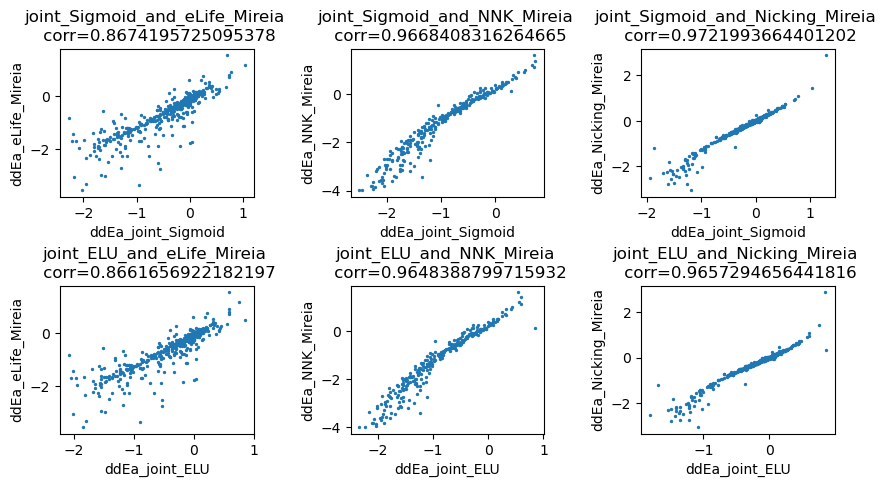

In [62]:
# plotting for run with all 3 doubles datasets

fig, axs = plt.subplots(2, 3, 
                        figsize=(10, 5))
fig.subplots_adjust(hspace=0.6, wspace = 0.5)
#fig.tight_layout()

#fig.supxlabel('Observed phenotype')
#fig.supylabel('Predicted phenotype')


axs[0,0].scatter(data = scatter_dfs['joint_Sigmoid_and_eLife_Mireia'], 
                x = 'ddEa_joint_Sigmoid', y = 'ddEa_eLife_Mireia', s=2)

axs[0,0].set_title('joint_Sigmoid_and_eLife_Mireia \n corr=' +  
                  str(np.corrcoef(scatter_dfs['joint_Sigmoid_and_eLife_Mireia']['ddEa_eLife_Mireia'], 
                              scatter_dfs['joint_Sigmoid_and_eLife_Mireia']['ddEa_joint_Sigmoid'])[0][1])
)
axs[0,0].set_xlabel('ddEa_joint_Sigmoid')
axs[0,0].set_ylabel('ddEa_eLife_Mireia')

axs[1,0].scatter(data = scatter_dfs['joint_ELU_and_eLife_Mireia'], 
                x = 'ddEa_joint_ELU', y = 'ddEa_eLife_Mireia', s=2)
axs[1,0].set_title('joint_ELU_and_eLife_Mireia \n corr=' +  
                  str(np.corrcoef(scatter_dfs['joint_ELU_and_eLife_Mireia']['ddEa_eLife_Mireia'], 
                              scatter_dfs['joint_ELU_and_eLife_Mireia']['ddEa_joint_ELU'])[0][1])
)
axs[1,0].set_xlabel('ddEa_joint_ELU')
axs[1,0].set_ylabel('ddEa_eLife_Mireia')



axs[0,1].scatter(data = scatter_dfs['joint_Sigmoid_and_NNK_Mireia'], 
                x = 'ddEa_joint_Sigmoid', y = 'ddEa_NNK_Mireia', s=2)
axs[0,1].set_title('joint_Sigmoid_and_NNK_Mireia \n corr=' +  
                  str(np.corrcoef(scatter_dfs['joint_Sigmoid_and_NNK_Mireia']['ddEa_NNK_Mireia'], 
                              scatter_dfs['joint_Sigmoid_and_NNK_Mireia']['ddEa_joint_Sigmoid'])[0][1])
)
axs[0,1].set_xlabel('ddEa_joint_Sigmoid')
axs[0,1].set_ylabel('ddEa_NNK_Mireia')


axs[1,1].scatter(data = scatter_dfs['joint_ELU_and_NNK_Mireia'], 
                x = 'ddEa_joint_ELU', y = 'ddEa_NNK_Mireia', s=2)
axs[1,1].set_title('joint_ELU_and_NNK_Mireia \n corr=' +  
                  str(np.corrcoef(scatter_dfs['joint_ELU_and_NNK_Mireia']['ddEa_NNK_Mireia'], 
                              scatter_dfs['joint_ELU_and_NNK_Mireia']['ddEa_joint_ELU'])[0][1])
)
axs[1,1].set_xlabel('ddEa_joint_ELU')
axs[1,1].set_ylabel('ddEa_NNK_Mireia')


axs[0,2].scatter(data = scatter_dfs['joint_Sigmoid_and_Nicking_Mireia'], 
                x = 'ddEa_joint_Sigmoid', y = 'ddEa_Nicking_Mireia', s=2)
axs[0,2].set_title('joint_Sigmoid_and_Nicking_Mireia \n corr=' +  
                  str(np.corrcoef(scatter_dfs['joint_Sigmoid_and_Nicking_Mireia']['ddEa_Nicking_Mireia'], 
                              scatter_dfs['joint_Sigmoid_and_Nicking_Mireia']['ddEa_joint_Sigmoid'])[0][1])
)
axs[0,2].set_xlabel('ddEa_joint_Sigmoid')
axs[0,2].set_ylabel('ddEa_Nicking_Mireia')


axs[1,2].scatter(data = scatter_dfs['joint_ELU_and_Nicking_Mireia'], 
                x = 'ddEa_joint_ELU', y = 'ddEa_Nicking_Mireia', s=2)
axs[1,2].set_title('joint_ELU_and_Nicking_Mireia \n corr=' +  
                  str(np.corrcoef(scatter_dfs['joint_ELU_and_Nicking_Mireia']['ddEa_Nicking_Mireia'], 
                              scatter_dfs['joint_ELU_and_Nicking_Mireia']['ddEa_joint_ELU'])[0][1])
)
axs[1,2].set_xlabel('ddEa_joint_ELU')
axs[1,2].set_ylabel('ddEa_Nicking_Mireia')





#plt.savefig('./figures/20240212_all_3_doubles_1st_ord_terms_allowed_ELU_Sigmoid_models_vs_Mireia_models_per_dataset_l2_1e-05.pdf',
#           bbox_inches = 'tight')